# Manual lookup

In [1]:
import itertools
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from coffea import nanoevents
import vector
import fastjet
import math
import matplotlib.pyplot as plt
import matplotlib
import mplhep as hep
from numba import njit
import hist
from hist import Hist

In [2]:
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.style.use(hep.style.CMS)

In [3]:
vector.register_awkward()

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def open_file(filename):
    file = nanoevents.NanoEventsFactory.from_root(
        filename, 
        schemaclass=nanoevents.NanoAODSchema
    )
    events = file.events()
    events = events[events.HLT.TripleMu_5_3_3_Mass3p8_DZ == 1]
    muon_mask = (
        events.Muon.mediumId
        & (events.Muon.pt > 3)
        & (abs(events.Muon.dxy) <= 0.02)
        & (abs(events.Muon.dz) <= 0.1)
        & (abs(events.Muon.eta) < 2.4)
    )
    num_mu_cut = ak.num(events.Muon[muon_mask], axis=-1) >= 4
    events = events[num_mu_cut]
    return events, events.Muon[muon_mask[num_mu_cut]]

In [6]:
# Some common paths
xrd_path = 'root://cmseos.fnal.gov//store/user'
skims_path = 'lpcsuep/SUEPNano_skimmed_merged'
campaign1 = 'pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1'
campaign2 = 'pythia8+RunIISummer19UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1'

ZZTo4L = f'{xrd_path}/{skims_path}/ZZTo4L_TuneCP5_13TeV_powheg_{campaign1}-v2+MINIAODSIM/skim_1.root'
DYJ = f'{xrd_path}/{skims_path}/DY4JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-{campaign2}-v1+MINIAODSIM/skim_1.root'
QCD_Pt = f'{xrd_path}/{skims_path}/QCD_Pt_800to1000_TuneCP5_13TeV_{campaign1}-v1+MINIAODSIM/skim_3.root'
TTJets = f'{xrd_path}/{skims_path}/TTJets_TuneCP5_13TeV-amcatnloFXFX-{campaign1}-v2+MINIAODSIM/skim_1.root'
signal = f'{xrd_path}/chpapage/SUEP_signal_private/SUEP-m400-darkPhoHad+RunIIAutumn18-private+MINIAODSIM.root'

In [7]:
evts_qcd, muons_qcd = open_file(QCD_Pt)
evts_tt, muons_tt = open_file(TTJets)
evts_s, muons_s = open_file(signal)

In [13]:
evts_s.w

<NanoEventsArray [<event 1:1:4>, ... <event 1:1:9896>] type='1466 * event'>

In [19]:
evts_s.GenPart[muons_s.genPartIdx].parent.pdgId

<Array [[999998, 999998, ... 999998, 999998]] type='1466 * var * ?int32[paramete...'>

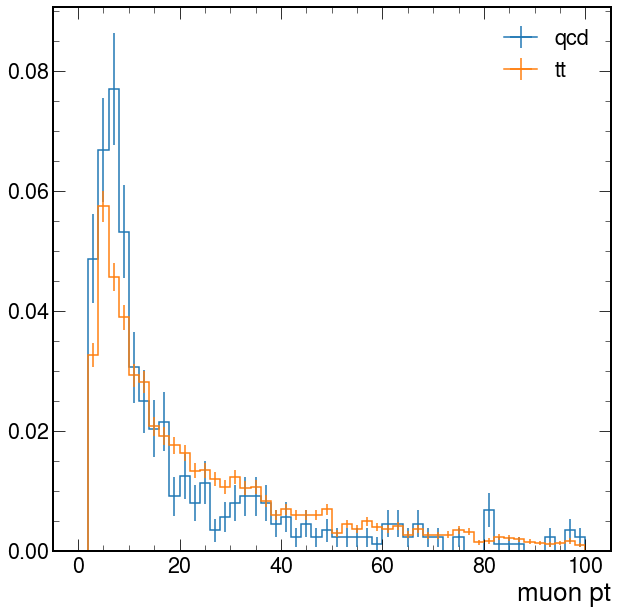

In [136]:
(
    Hist.new.Regular(50, 0, 100, name="qcd muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(muons_qcd.pt))
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(50, 0, 100, name="tt muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(muons_tt.pt))
    .plot(label="tt", density=True)
)
plt.legend()

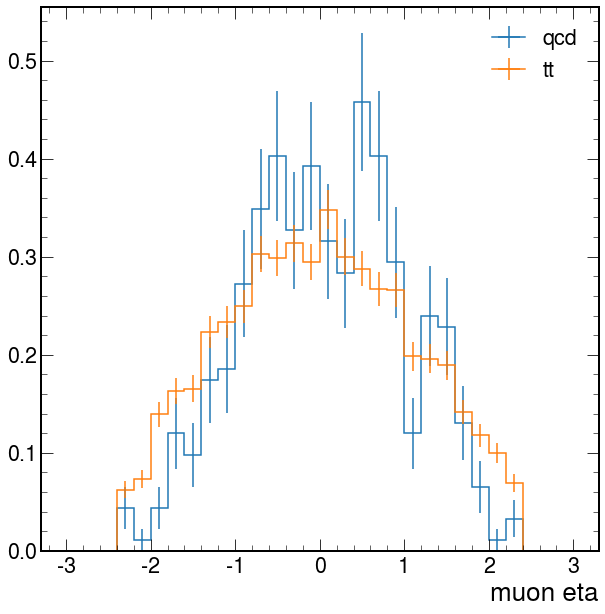

In [138]:
(
    Hist.new.Regular(30, -3, 3, name="qcd muon eta", label="muon eta")
    .Double()
    .fill(ak.flatten(muons_qcd.eta))
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(30, -3, 3, name="tt muon eta", label="muon eta")
    .Double()
    .fill(ak.flatten(muons_tt.eta))
    .plot(label="tt", density=True)
)
plt.legend()

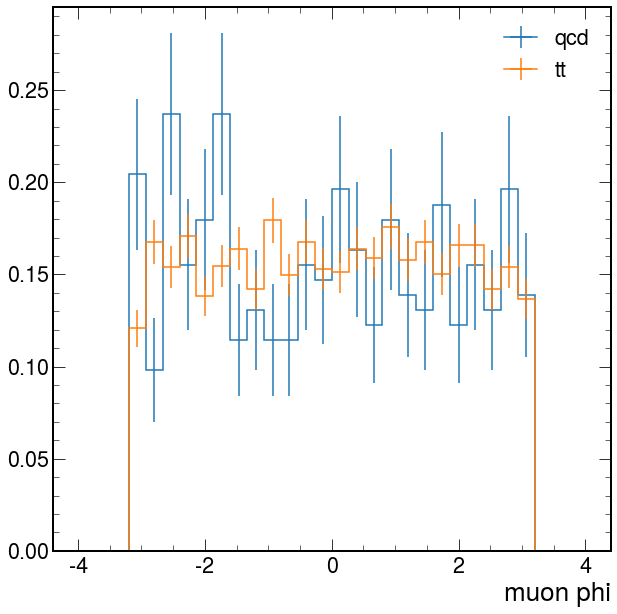

In [140]:
(
    Hist.new.Regular(30, -4, 4, name="qcd muon phi", label="muon phi")
    .Double()
    .fill(ak.flatten(muons_qcd.phi))
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(30, -4, 4, name="tt muon phi", label="muon phi")
    .Double()
    .fill(ak.flatten(muons_tt.phi))
    .plot(label="tt", density=True)
)
plt.legend()

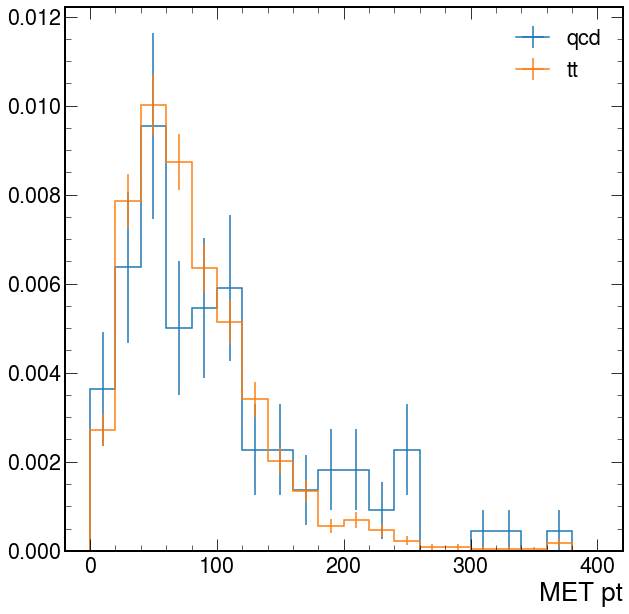

In [141]:
(
    Hist.new.Regular(20, 0, 400, name="qcd MET pt", label="MET pt")
    .Double()
    .fill(evts_qcd.MET.pt)
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(20, 0, 400, name="tt MET pt", label="MET pt")
    .Double()
    .fill(evts_tt.MET.pt)
    .plot(label="tt", density=True)
)
plt.legend()

In [142]:
def transverse_mass(particles, met):
    """Return the transverse mass of an array of particles and the missing transverse energy"""
    return np.sqrt(
        2 * particles.pt * met.pt * (1 - np.cos(particles.delta_phi(met)))
    )

In [143]:
mt_qcd = transverse_mass(muons_qcd, evts_qcd.MET)
mt_tt = transverse_mass(muons_tt, evts_tt.MET)

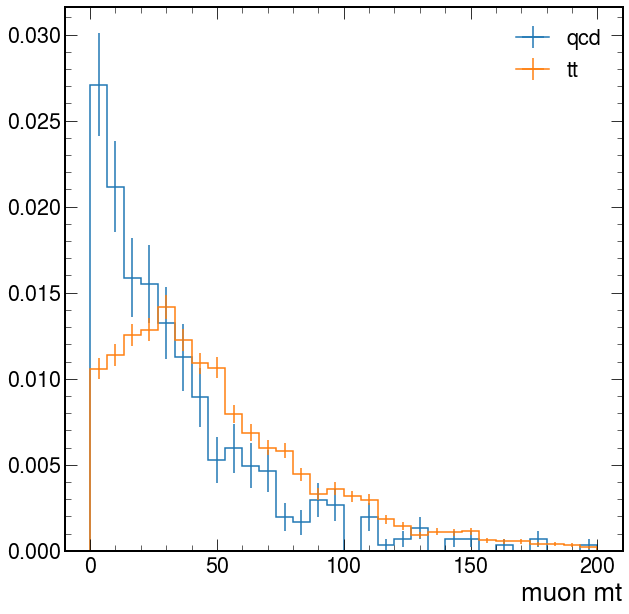

In [144]:
(
    Hist.new.Regular(30, 0, 200, name="qcd muon mt", label="muon mt")
    .Double()
    .fill(ak.flatten(mt_qcd))
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(30, 0, 200, name="tt muon mt", label="muon mt")
    .Double()
    .fill(ak.flatten(mt_tt))
    .plot(label="tt", density=True)
)
plt.legend()

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f58634ddf70>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f58634ea2b0>, text=[])

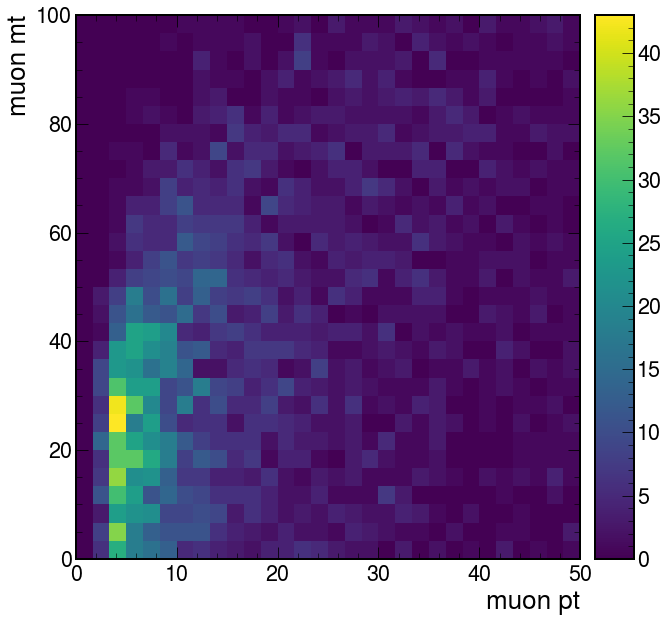

In [145]:
(
    Hist.new.Regular(30, 0, 50, name="tt muon pt", label="muon pt")
    .Regular(30, 0, 100, name="tt muon mt", label="muon mt")
    .Double()
    .fill(ak.flatten(muons_tt.pt), ak.flatten(mt_tt))
    .plot(label="tt")
)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f586335ec10>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f586338dc10>, text=[])

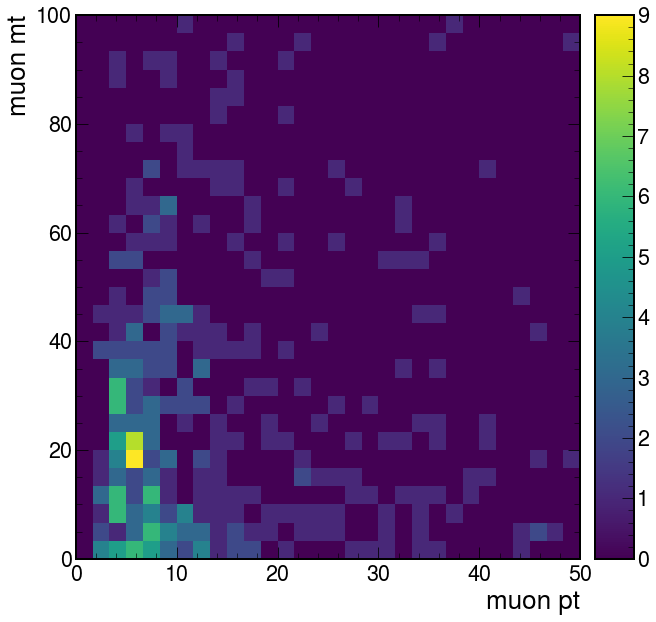

In [146]:
(
    Hist.new.Regular(30, 0, 50, name="qcd muon pt", label="muon pt")
    .Regular(30, 0, 100, name="qcd muon mt", label="muon mt")
    .Double()
    .fill(ak.flatten(muons_qcd.pt), ak.flatten(mt_qcd))
    .plot(label="qcd")
)

In [147]:
print(mt_tt[0,:])

[77.6, 61.9, 80.8, 66.5]


In [148]:
print(evts_tt.Muon.pt[0,:])

[21.3, 13.2, 13.2, 8.98]


In [149]:
print(mt_qcd[0,:])

[150, 4.49, 80, 5.39]


In [151]:
print(np.sqrt(muons_qcd.pt[0,:]**2 + mt_qcd[0,:]**2))

[155, 19.1, 80.7, 8.85]


In [152]:
print(np.sqrt(muons_tt.pt[0,:]**2 + mt_tt[0,:]**2))

[80.4, 63.3, 81.9, 67.1]


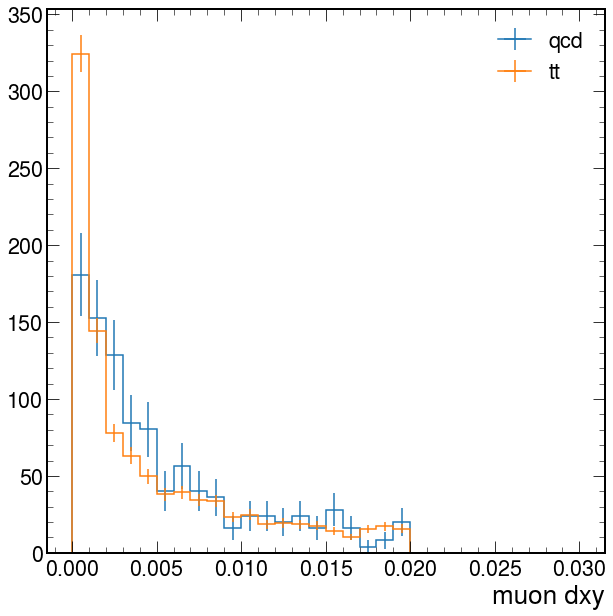

In [155]:
(
    Hist.new.Regular(30, 0, 0.03, name="qcd muon dxy", label="muon dxy")
    .Double()
    .fill(ak.flatten(muons_qcd.dxy))
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(30, 0, 0.03, name="tt muon dxy", label="muon dxy")
    .Double()
    .fill(ak.flatten(muons_tt.dxy))
    .plot(label="tt", density=True)
)
plt.legend()

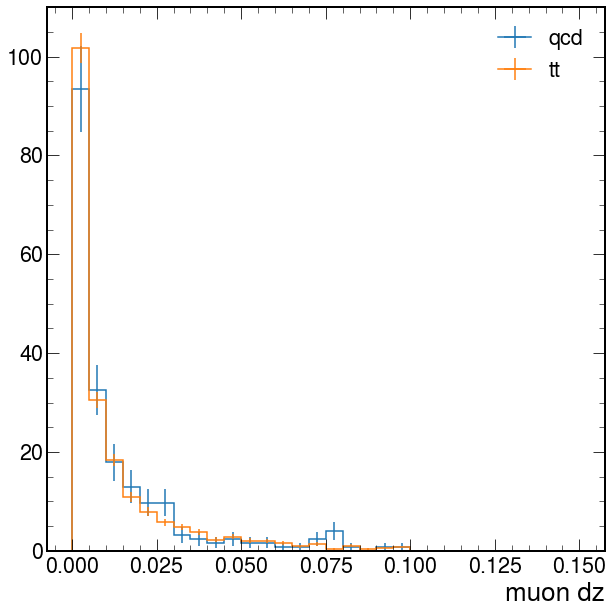

In [158]:
(
    Hist.new.Regular(30, 0, 0.15, name="qcd muon dz", label="muon dz")
    .Double()
    .fill(ak.flatten(muons_qcd.dz))
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(30, 0, 0.15, name="tt muon dz", label="muon dz")
    .Double()
    .fill(ak.flatten(muons_tt.dz))
    .plot(label="tt", density=True)
)
plt.legend()

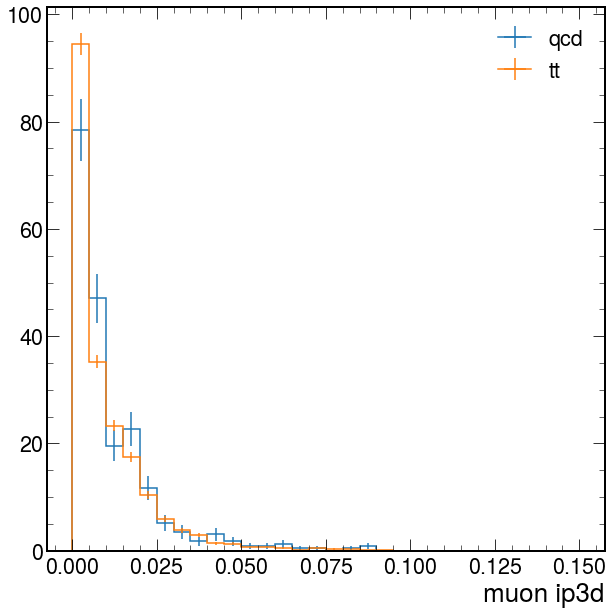

In [159]:
(
    Hist.new.Regular(30, 0, 0.15, name="qcd muon ip3d", label="muon ip3d")
    .Double()
    .fill(ak.flatten(muons_qcd.ip3d))
    .plot(label="qcd", density=True)
)
(
    Hist.new.Regular(30, 0, 0.15, name="tt muon ip3d", label="muon ip3d")
    .Double()
    .fill(ak.flatten(muons_tt.ip3d))
    .plot(label="tt", density=True)
)
plt.legend()

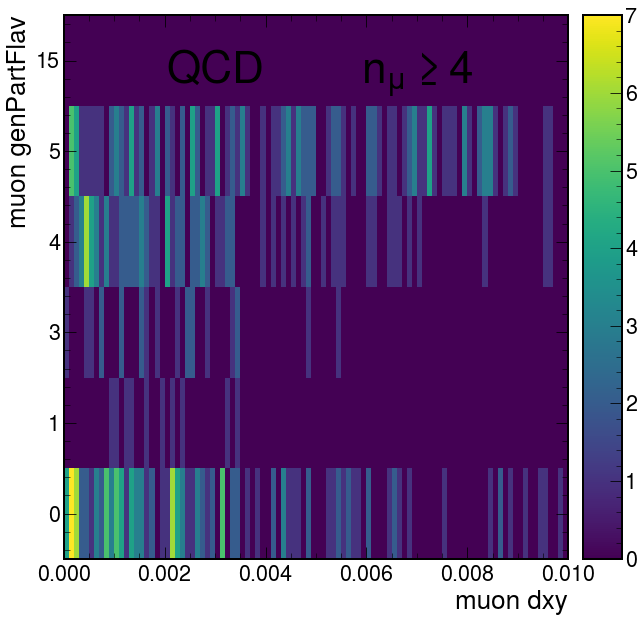

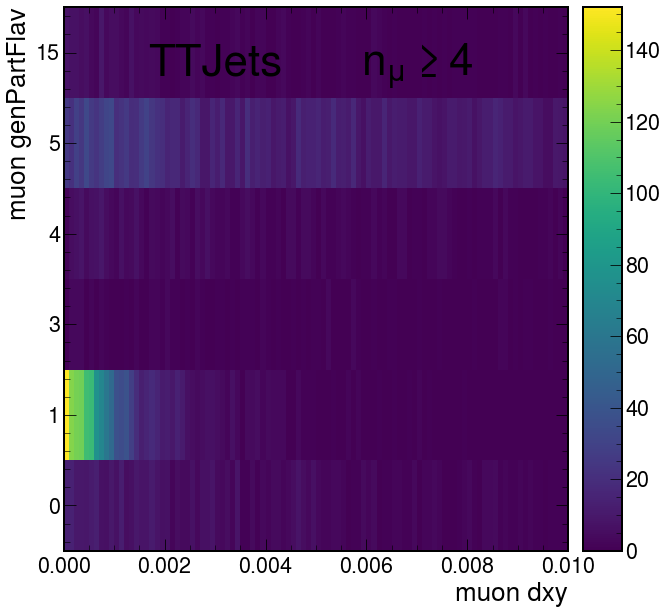

In [228]:
xmax = 0.01
(
    Hist.new.Regular(100, 0, xmax, name="qcd muon dxy", label="muon dxy")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_qcd.dxy)), ak.flatten(muons_qcd.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "QCD", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.Regular(100, 0, xmax, name="tt muon dxy", label="muon dxy")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_tt.dxy)), ak.flatten(muons_tt.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "TTJets", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

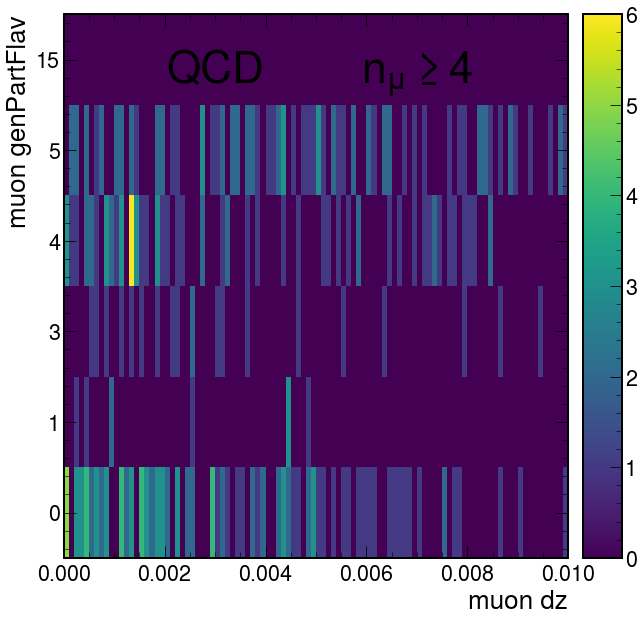

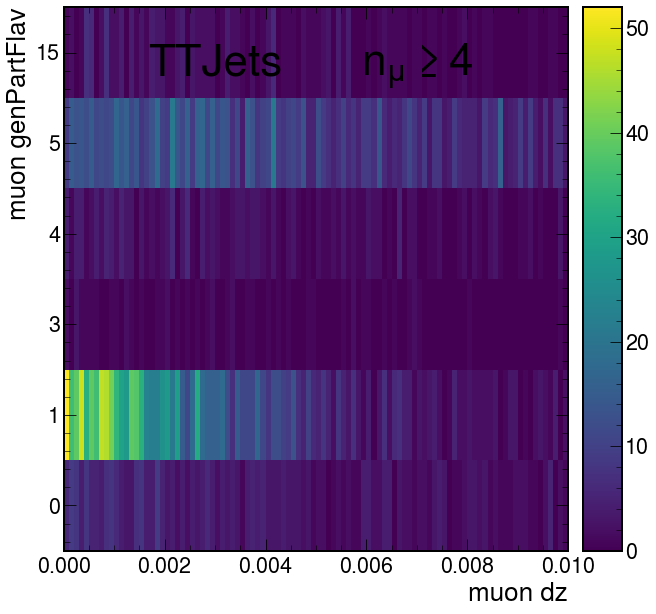

In [226]:
xmax = 0.01
(
    Hist.new.Regular(100, 0, xmax, name="qcd muon dz", label="muon dz")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_qcd.dz)), ak.flatten(muons_qcd.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "QCD", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.Regular(100, 0, xmax, name="tt muon dz", label="muon dz")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_tt.dz)), ak.flatten(muons_tt.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "TTJets", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

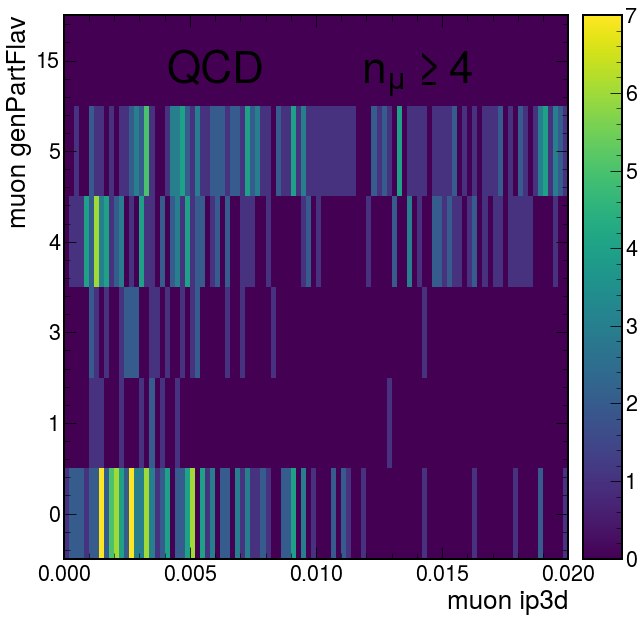

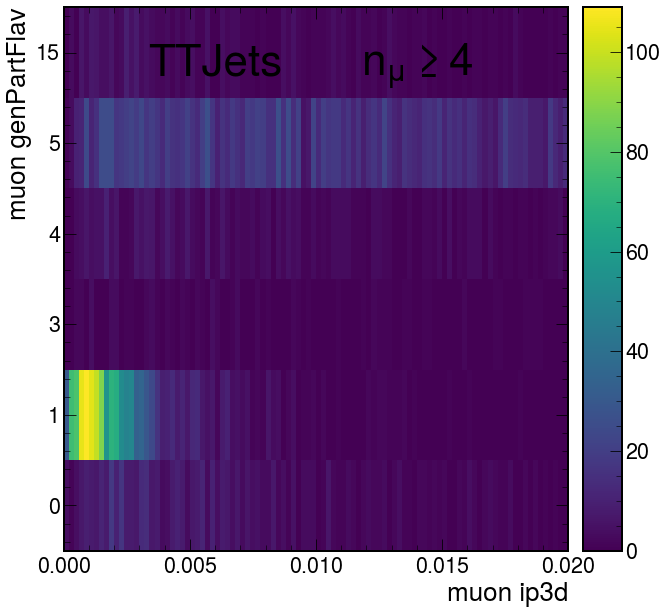

In [229]:
xmax = 0.02
(
    Hist.new.Regular(100, 0, xmax, name="qcd muon ip3d", label="muon ip3d")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_qcd.ip3d), ak.flatten(muons_qcd.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "QCD", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.Regular(100, 0, xmax, name="tt muon ip3d", label="muon ip3d")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_tt.ip3d), ak.flatten(muons_tt.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "TTJets", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

In [21]:
ak.max(ak.flatten(muons_tt.miniPFRelIso_all))

72.72883

In [22]:
ak.max(ak.flatten(muons_tt.pfRelIso03_all))

86.71873

In [23]:
ak.max(ak.flatten(muons_tt.pfRelIso04_all))

90.55953

In [24]:
ak.max(ak.flatten(muons_tt.multiIsoId))

2

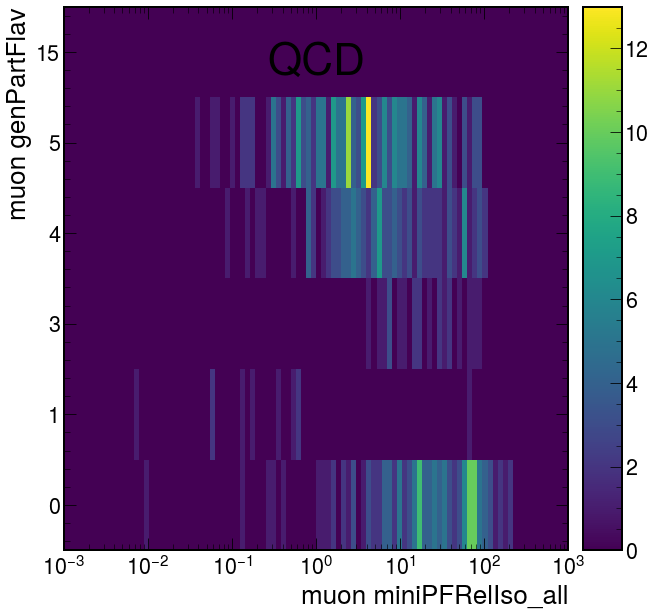

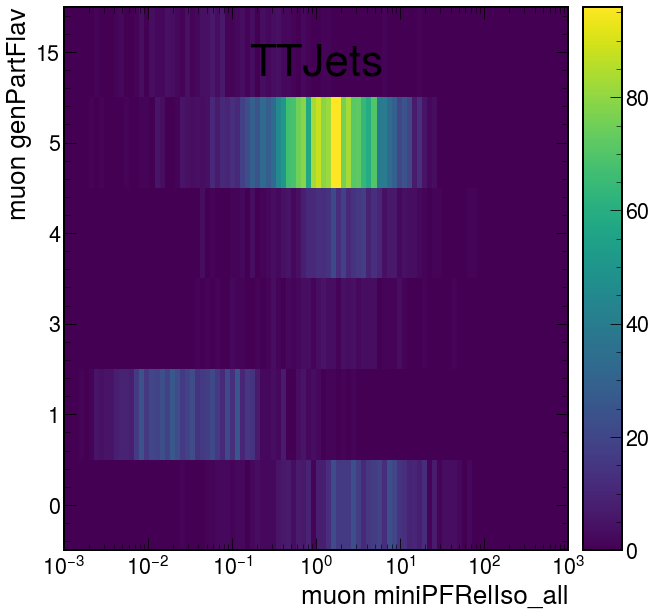

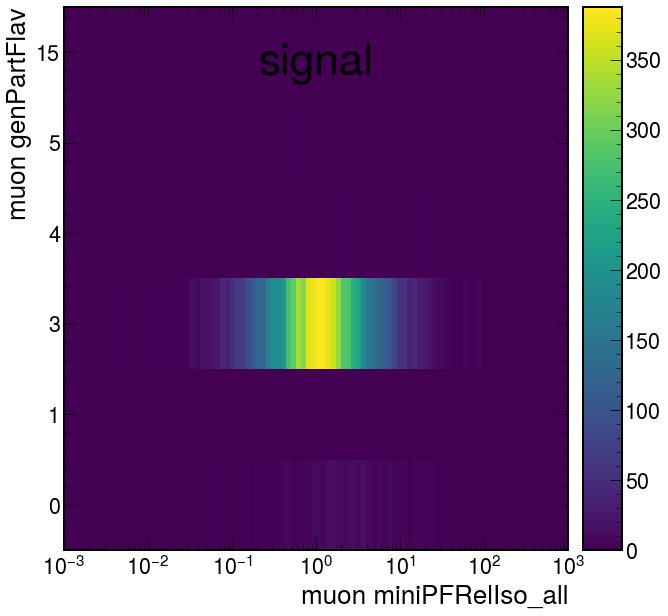

In [45]:
(
    Hist.new.Reg(
        100, 1e-3, 1000, name="muon miniPFRelIso_all", 
        label="muon miniPFRelIso_all", transform=hist.axis.transform.log
    )
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_qcd.miniPFRelIso_all), ak.flatten((muons_qcd.genPartFlav)))
    .plot2d()#norm=matplotlib.colors.LogNorm())
)
plt.xscale('log')
plt.text(1, 5.25, "QCD", fontsize=44, ha='center')
#plt.text(3, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.Reg(
        100, 1e-3, 1000, name="muon miniPFRelIso_all", 
        label="muon miniPFRelIso_all", transform=hist.axis.transform.log
    )
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_tt.miniPFRelIso_all), ak.flatten((muons_tt.genPartFlav)))
    .plot2d()#norm=matplotlib.colors.LogNorm())
)
plt.xscale('log')
plt.text(1, 5.25, "TTJets", fontsize=44, ha='center')
#plt.text(3, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.Reg(
        100, 1e-3, 1000, name="muon miniPFRelIso_all", 
        label="muon miniPFRelIso_all", transform=hist.axis.transform.log
    )
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_s.miniPFRelIso_all), ak.flatten((muons_s.genPartFlav)))
    .plot2d()#norm=matplotlib.colors.LogNorm())
)
plt.xscale('log')
plt.text(1, 5.25, "signal", fontsize=44, ha='center')
#plt.text(3, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

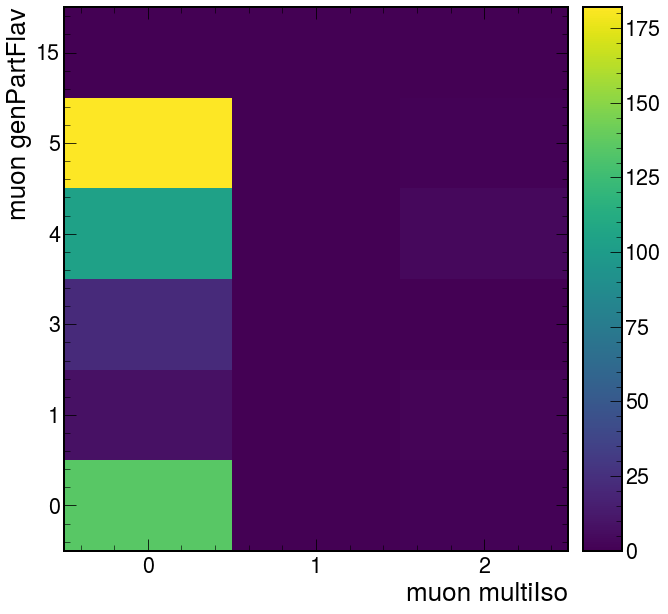

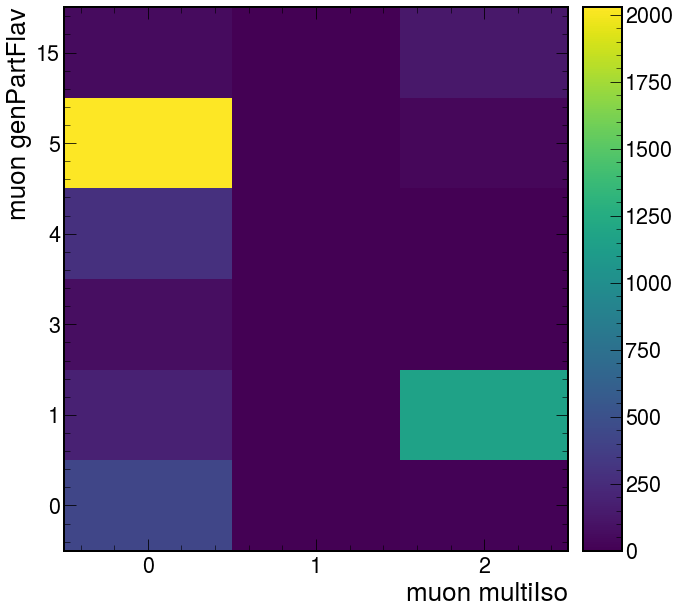

In [42]:
(
    Hist.new.IntCat([0, 1, 2], name="muon multiIso", label="muon multiIso")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_qcd.multiIsoId), ak.flatten((muons_qcd.genPartFlav)))
    .plot2d()#norm=matplotlib.colors.LogNorm())
)
#plt.text(1, 5.25, "QCD", fontsize=44, ha='center')
#plt.text(3, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.IntCat([0, 1, 2], name="muon multiIso", label="muon multiIso")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_tt.multiIsoId), ak.flatten((muons_tt.genPartFlav)))
    .plot2d()#norm=matplotlib.colors.LogNorm())
)
#plt.text(1, 5.25, "TTJets", fontsize=44, ha='center')
#plt.text(3, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.IntCat([0, 1, 2], name="muon multiIso", label="muon multiIso")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_s.multiIsoId), ak.flatten((muons_s.genPartFlav)))
    .plot2d()#norm=matplotlib.colors.LogNorm())
)
#plt.text(1, 5.25, "TTJets", fontsize=44, ha='center')
#plt.text(3, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

In [ ]:
(
    Hist.new.Regular(100, 0, xmax, name="qcd muon pfiso", label="muon pfiso")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_qcd.dxy)), ak.flatten(muons_qcd.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "QCD", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.Regular(100, 0, xmax, name="tt muon dxy", label="muon dxy")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_tt.dxy)), ak.flatten(muons_tt.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "TTJets", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

In [ ]:
(
    Hist.new.Regular(100, 0, xmax, name="qcd muon dxy", label="muon dxy")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_qcd.dxy)), ak.flatten(muons_qcd.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "QCD", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

(
    Hist.new.Regular(100, 0, xmax, name="tt muon dxy", label="muon dxy")
    .IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(abs(muons_tt.dxy)), ak.flatten(muons_tt.genPartFlav))
    .plot2d()
)
plt.text(0.3*xmax, 5.25, "TTJets", fontsize=44, ha='center')
plt.text(0.7*xmax, 5.25, r"$n_{\mu}\geq4$", fontsize=44, ha='center')
plt.show()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f58618d3190>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

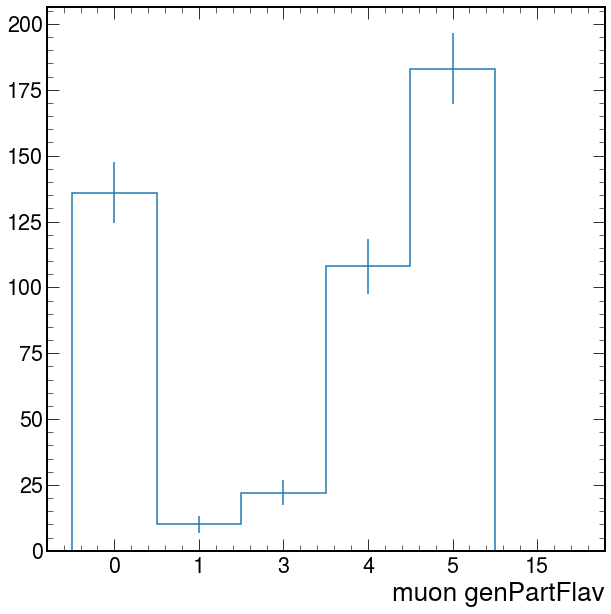

In [173]:
(
    Hist.new.IntCategory([0, 1, 3, 4, 5, 15], name="muon genPartFlav", label="muon genPartFlav")
    .Double()
    .fill(ak.flatten(muons_qcd.genPartFlav))
    .plot(label="qcd")
)

In [129]:
genMuons = events.GenPart[abs(events.GenPart.pdgId) == 13]
genMuons = genMuons[genMuons.pt >= 3]
genMuons = genMuons[abs(genMuons.eta) < 2.5]
genMuons = genMuons[genMuons.status < 30]

Gen muons seem to have only 4 status codes (all positive -- final):
- `1` : just final state partilce?
- `23` : particles of the hardest subprocess, outgoing
- `51` : particles produced by final-state-showers, outgoing produced by parton branching
- `52` : particles produced by final-state-showers, outgoing copy of recoiler, with changed momentum

In [43]:
ak.num(genMuons)

<Array [4, 6, 5, 3, 6, 5, ... 6, 8, 6, 6, 4, 3] type='497 * int64'>

In [22]:
ak.flatten(genMuons[genMuons.status != 1]).status == 23

<Array [23, 23, 52, 51, 52, ... 23, 23, 23, 51] type='1075 * int32[parameters={"...'>

In [39]:
Jets_awk = ak.zip(
            {
                "pt": events.Jet.pt,
                "eta": events.Jet.eta,
                "phi": events.Jet.phi,
                "mass": events.Jet.mass,
                "btagDeepB": events.Jet.btagDeepB,
            }
)
jet_awk_Cut = (events.Jet.pt > 30) & (abs(events.Jet.eta) < 2.4)
Jets_correct = Jets_awk[jet_awk_Cut]

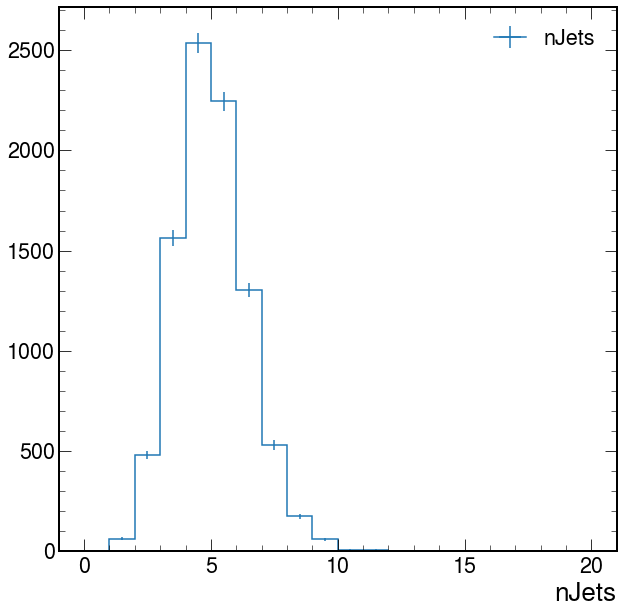

In [72]:
h1 = Hist.new.Regular(20, 0, 20, name="nJets", label="nJets").Double()
h1.fill(ak.num(Jets_correct))
hep.histplot(h1, label="nJets")
plt.legend()
#plt.yscale('log')

In [75]:
btag = Jets_correct.btagDeepB
btag = btag[:, :4]

In [80]:
ak.sum(ak.num(btag) < 4)

2103

In [86]:
btag_fixed = ak.pad_none(btag, target=4, axis=-1)

In [104]:
ak.fill_none(btag_fixed, -2)

<Array [[0.569, 0.011, ... 0.0247, 0.0286]] type='8959 * var * float64'>

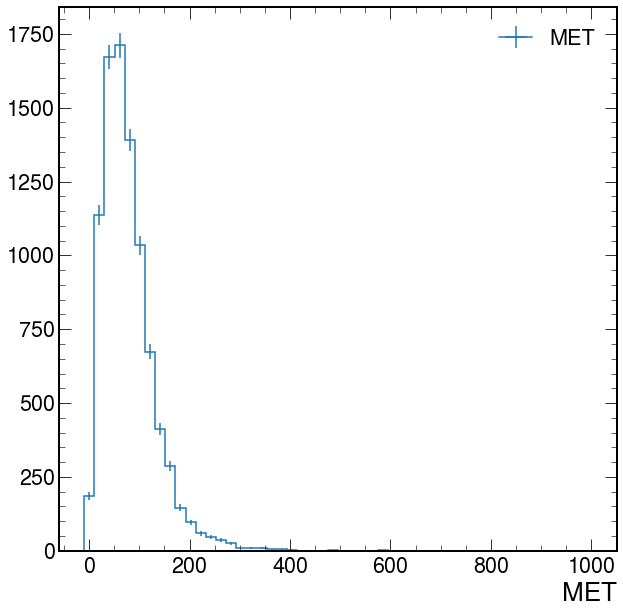

In [73]:
h1 = Hist.new.Regular(50, -10, 1000, name="MET", label="MET").Double()
h1.fill(events.MET.pt)
hep.histplot(h1, label="MET")
plt.legend()
#plt.yscale('log')

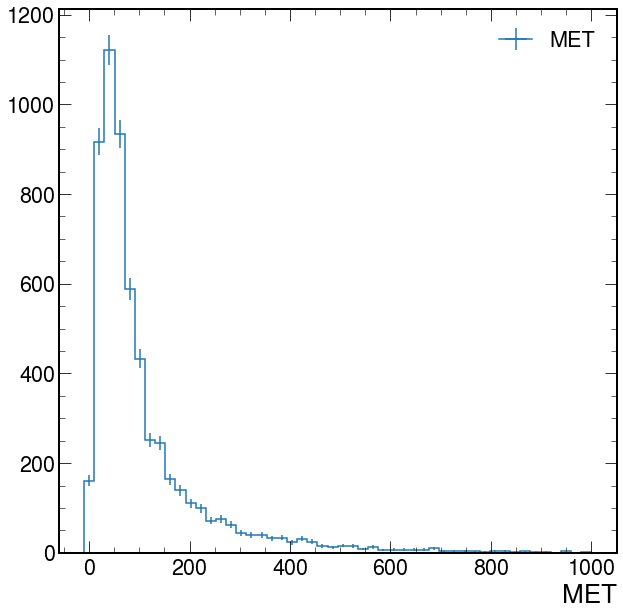

In [71]:
h1 = Hist.new.Regular(50, -10, 1000, name="MET", label="MET").Double()
h1.fill(events.MET.pt)
hep.histplot(h1, label="MET")
plt.legend()
#plt.yscale('log')

In [63]:
h1

Hist(Regular(50, -100, 3000, name='MET', label='MET'), storage=Double()) # Sum: 3404.0 (5349.0 with flow)

In [80]:
ak.max(events.Jet.btagDeepB[:,:2], axis=-1)

<Array [0.569, 0.158, 0.959, ... 1, 0.723] type='8959 * ?float32'>

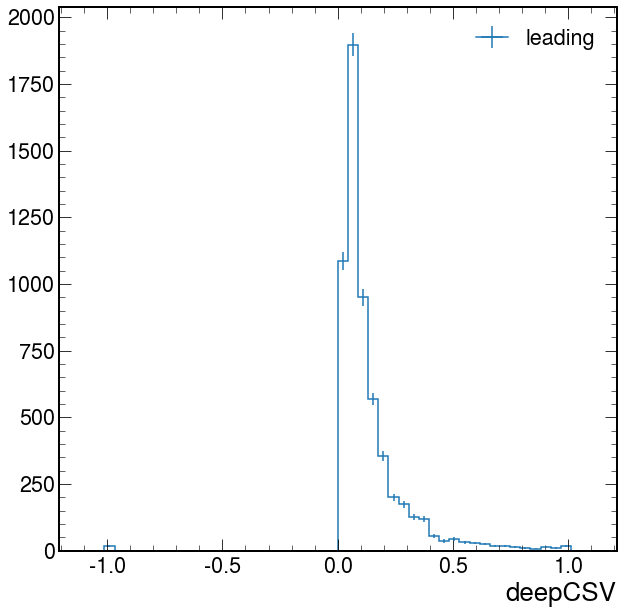

In [85]:
h1 = Hist.new.Regular(50, -1.1, 1.1, name="deepCSV 1", label="deepCSV").Double()
h1.fill(ak.max(events.Jet.btagDeepB[:,:2], axis=-1))
hep.histplot(h1, label="leading")
plt.legend()
#plt.yscale('log')

In [91]:
h = Hist.new.Reg(20,0,20,name='nMuons').Weight()
h.fill(ak.num(events.Muon.mediumId == 1), weight=events.genWeight)

Hist(Regular(20, 0, 20, name='nMuons', label='nMuons'), storage=Weight()) # Sum: WeightedSum(value=37.9161, variance=0.715664)

In [92]:
factor

0.0035316196502400005

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f94b65135b0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

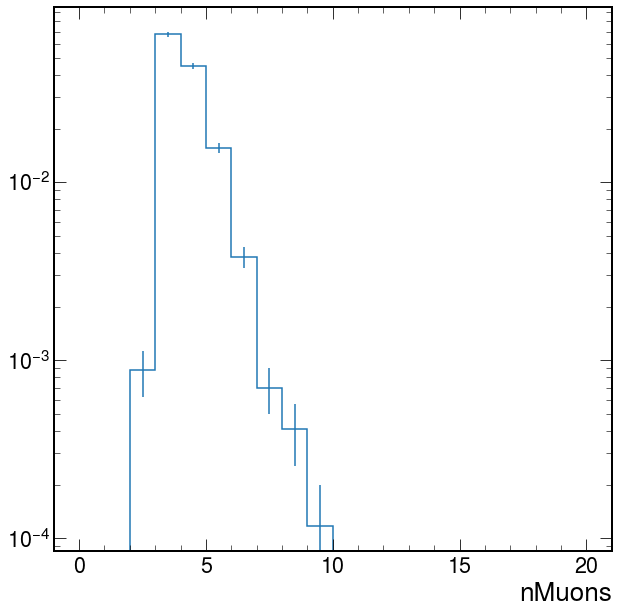

In [93]:
plt.yscale('log')
h *= factor
h.plot()

In [76]:
h.sum()

WeightedSum(value=882.905, variance=388.052)

In [36]:
h_s = h

In [41]:
h_b = h

In [44]:
np.linspace(0,20,21)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [45]:
binning = np.linspace(0,20,21)
alpha = 2
beta = 5
n_bins = h_s.shape[0]
S = np.zeros(n_bins)
B = np.zeros(n_bins)
punzi1 = np.zeros(n_bins)
punzi2 = np.zeros(n_bins)
punzi3 = np.zeros(n_bins)
s_over_b = np.zeros(n_bins)
s_over_b_and_s = np.zeros(n_bins)
for i in range(n_bins):
    S[i] = h_s[i:].sum().value
    B[i] = h_b[i:].sum().value
    epsilon = S[i]/h_s.sum().value
    punziCommon = alpha*math.sqrt(B[i])+(beta/2)*math.sqrt(beta**2+4*alpha*math.sqrt(B[i])+4*B[i])
    punzi1[i] = epsilon / ((alpha**2)/2 + math.sqrt(B[i]))
    punzi2[i] = epsilon / ((beta**2)/2 + punziCommon)
    punzi3[i] = epsilon / ((alpha**2)/8 + 9*(beta**2)/13 + punziCommon)
    if B[i] > 0:
        s_over_b[i] = epsilon / math.sqrt(B[i])
    if (B[i] + S[i]) > 0:
        s_over_b_and_s[i] = epsilon / math.sqrt(B[i] + S[i])
print(f"punzi max at: {binning[np.argmax(punzi3)]}")

punzi max at: 7.0


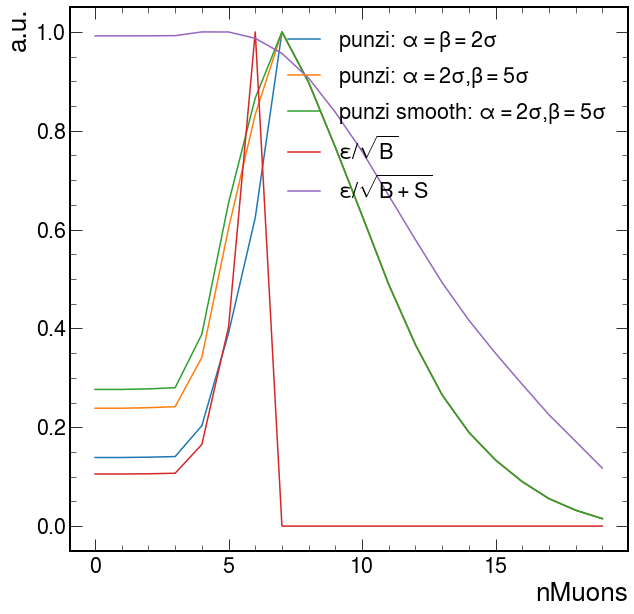

In [48]:
binning = np.linspace(0,19,20)
plt.plot(binning, punzi1/np.max(punzi1), label=r'punzi: $\alpha=\beta=2\sigma$')
plt.plot(binning, punzi2/np.max(punzi2), label=r'punzi: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, punzi3/np.max(punzi3), label=r'punzi smooth: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, s_over_b/np.max(s_over_b), label=r'$\epsilon/\sqrt{B}$')
plt.plot(binning, s_over_b_and_s/np.max(s_over_b_and_s), label=r'$\epsilon/\sqrt{B+S}$')
plt.xlabel('nMuons')
plt.ylabel('a.u.')
plt.legend()

In [31]:
array1 = events.event.to_numpy()[:5]
array2 = events.event.to_numpy()[5:10]

In [32]:
dframe1 = pd.DataFrame(array1, columns=['event'])
dframe2 = pd.DataFrame(array2, columns=['event'])

In [47]:
dframe = pd.concat([dframe1.reset_index(drop=True), dframe2.reset_index(drop=True)])

In [49]:
dframe.reset_index(drop=True)

,event
0,8901672
1,19197151
2,5103767
3,5235490
4,14815079
5,16943876
6,13490734
7,13480518
8,13653190
9,16943876


In [8]:
ak.num(events.HLT.TripleMu_5_3_3_Mass3p8_DZ, axis=0)

195

In [166]:
h_dimuon_mass = hist.Hist.new.Regular(150, 0, 150, name="dimuon mass").Double()

In [392]:
Muons = events.Muon
cutMuons = (
    events.Muon.looseId
    & (events.Muon.pt > 3)
    & (abs(events.Muon.dxy) <= 0.02)
    & (abs(events.Muon.dz) <= 0.1)
    & (abs(events.Muon.eta) < 2.4)
)
Muons = Muons[cutMuons]
eventSelection = ak.num(Muons) >= 3
events = events[eventSelection]
Muons = Muons[eventSelection]
muons = ak.zip(
    {
        "pt": Muons.pt,
        "eta": Muons.eta,
        "phi": Muons.phi,
        "mass": Muons.mass,
        "charge": Muons.pdgId / (-13),
    },
    with_name="Momentum4D",
)

In [393]:
print(Muons[:2].eta)

[[-0.548, 1.51, 0.61], [0.938, 0.928, 0.255]]


In [394]:
print(Muons.nearest(events.Jet)[:2].eta)

[[-0.587, 1.53, 0.625], [0.942, 0.942, 0.253]]


In [395]:
gen_muons_nearest = Muons.nearest(events.GenPart)

In [396]:
gen_muons = events.GenPart[abs(events.GenPart.pdgId) == 13]

In [397]:
gen_muons_final = gen_muons[gen_muons.status == 1]

In [398]:
nearest_muon_final = Muons.nearest(gen_muons_final)

In [24]:
parents = nearest_muon_final[:2]
print("pdgId:", parents.pdgId)
print("status:", parents.status)

pdgId: [[13, -13, 13, -13], [13, -13, -13, 13]]
status: [[1, 1, 1, 1], [1, 1, 1, 1]]


In [35]:
print(parents[:2].pt)

[[131, 90.2, 62.9, 33.6], [63.8, 28.7, 9.47, 4.78]]


In [20]:
gen_muons[0].parent.parent.parent.parent.parent.pdgId

<Array [None, None, 1, 23, ... 1, 23, 23, None] type='14 * ?int32[parameters={"_...'>

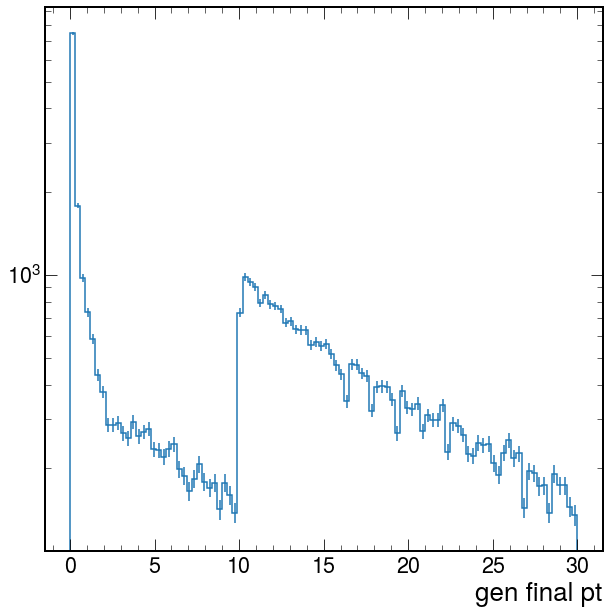

In [208]:
(
    Hist.new.Regular(100, 0, 30, name="gen final pt", label="gen final pt")
    .Double()
    .fill(ak.flatten(events.GenPart.pt[events.GenPart.status == 1]))
    .plot()
);
plt.yscale('log')

## Jet & Muons

In [177]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 6
Muons = Muons[num_muons_selection]

Jets = events.Jet
jet_cleaning = (
    (Jets.pt > 30)
    & (abs(Jets.eta) < 2.4)
)
Jets = Jets[jet_cleaning]
Jets = Jets[num_muons_selection]

In [178]:
matched_jets = Muons.nearest(Jets)
delta_r = Muons.delta_r(matched_jets)

In [179]:
ak.flatten(delta_r)

<Array [0.229, 0.0913, ... 0.0848, 0.116] type='20 * ?float32'>

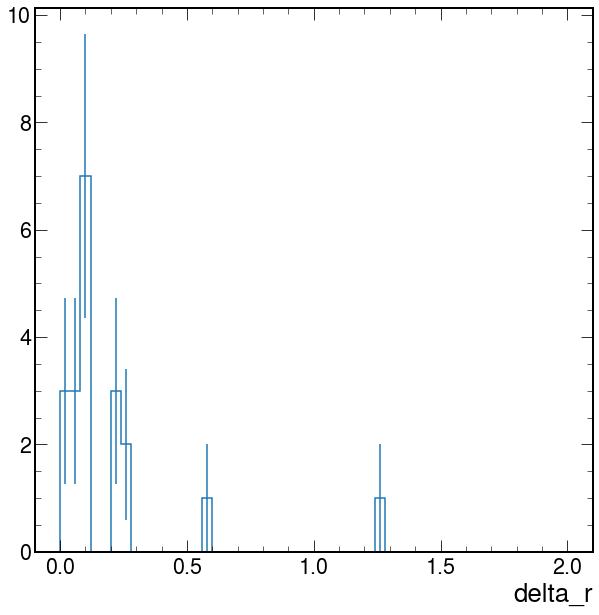

In [180]:
(
    Hist.new
    .Regular(50, 0, 2, name="delta_r", label="delta_r")
    .Double()
    .fill(ak.flatten(delta_r))
    .plot()
);

## Displayed vertices

In [194]:
print(ak.sum(~ak.is_none(events.Jet.matched_muons, axis=-1), axis=-1)[:2])

[[0, 1, 1, 1], [0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]]


In [199]:
print((events.Jet.pt > 0)[:2])

[[True, True, True, True], ... True, True, True, True, True, True, True, True, True]]


### Find the last non-muon parents for the gen-matched muons
**Step 1:** get the desired muons and the final status gen muons

In [253]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 3
Muons = Muons[num_muons_selection]

gen_mask_1 = (
    (abs(events.GenPart.pdgId) == 13) &
    (events.GenPart.status == 1)
)
gen_mask_2 = (
    (abs(events.GenPart.pdgId) != 13) &
    (events.GenPart.status == 1)
)

gen_parts_1 = events.GenPart[gen_mask_1]
gen_parts_1 = gen_parts_1[num_muons_selection]
gen_parts_2 = events.GenPart[gen_mask_2]
gen_parts_2 = gen_parts_2[num_muons_selection]
matched_1 = Muons.nearest(gen_parts_1)
matched_2 = Muons.nearest(gen_parts_2)
matched_f_1 = ak.mask(matched_1, Muons.delta_r(matched_1) < 0.1)
matched_f_2 = ak.mask(matched_2, Muons.delta_r(matched_2) < 0.1)

matched_f = ak.where(~ak.is_none(matched_f_1, axis=1), matched_f_1, matched_f_2)

In [260]:
matched_f.phi

<Array [[0.754, -3.08, ... -0.566, -1.29]] type='911 * var * ?float32[parameters...'>

**Step 3:** Form the array with the last non-muon parents

In [261]:
# Begin with the matched gen muons
temp_parents = matched_f
# This mask keeps track of which non-muon parents have not appeared already. Initialize to True
has_not_appeared = ak.full_like(temp_parents.pt, True, dtype=bool)
# The useful parents are the last non-muon parents
last_parents = ak.mask(temp_parents, ~has_not_appeared)
# Terminate when none of the particles is a muon
while ak.any(abs(temp_parents.pdgId) == 13):
    # Create mask of the particles that are not muons and have not already been kept
    mask = (abs(temp_parents.pdgId) != 13) & has_not_appeared
    # Create the parents collection that includes all non-muon parents
    parents = ak.zip(
        {
            "pt": ak.mask(temp_parents, mask).pt,
            "eta": ak.mask(temp_parents, mask).eta,
            "phi": ak.mask(temp_parents, mask).phi,
            "M": ak.mask(temp_parents, mask).mass,
            "pdgId": ak.mask(temp_parents, mask).pdgId,
            "status": ak.mask(temp_parents, mask).status,
        },
        with_name="Momentum4D",
    )
    # Remove the parents that were found from the mask
    has_not_appeared = has_not_appeared & ~mask
    # Add the parents that are not None
    last_parents = ak.where(ak.fill_none(parents.pt, 0) > 0, parents, last_parents)
    # Get the parents of the particles
    temp_parents = temp_parents.parent

... and second-to-last non-muon parents

In [262]:
# Begin with the matched gen muons
temp_parents = matched_f
parents_of_parents = temp_parents.parent
# This mask keeps track of which non-muon parents have not appeared already. Initialize to True
has_not_appeared = ak.full_like(temp_parents.pt, True, dtype=bool)
# The useful parents are the last non-muon parents
last2nd_parents = ak.mask(temp_parents, ~has_not_appeared)
# Terminate when none of the particles is a muon
while ak.any(abs(temp_parents.pdgId) == 13):
    # Create mask of the particles that are not muons and have not already been kept
    mask = (abs(temp_parents.pdgId) != 13) & has_not_appeared
    # Create the parents collection that includes all non-muon parents
    parents = ak.zip(
        {
            "pt": ak.mask(parents_of_parents, mask).pt,
            "eta": ak.mask(parents_of_parents, mask).eta,
            "phi": ak.mask(parents_of_parents, mask).phi,
            "M": ak.mask(parents_of_parents, mask).mass,
            "pdgId": ak.mask(parents_of_parents, mask).pdgId,
            "status": ak.mask(parents_of_parents, mask).status,
        },
        with_name="Momentum4D",
    )
    # Remove the parents that were found from the mask
    has_not_appeared = has_not_appeared & ~mask
    # Add the parents that are not None
    last2nd_parents = ak.where(ak.fill_none(parents.pt, 0) > 0, parents, last2nd_parents)
    # Get the parents of the particles
    temp_parents = temp_parents.parent
    parents_of_parents = temp_parents.parent

... and the first non-proton parents

In [263]:
temp_parents = matched_f
first_parents = ak.mask(temp_parents, ak.full_like(temp_parents.pt, False, dtype=bool))
while ak.any(abs(temp_parents.pdgId)):
    temp_parents = temp_parents.parent
    next_parents = temp_parents.parent
    # Create mask of the particles whose parents are None and have not already been kept
    mask = (abs(ak.fill_none(next_parents.pdgId, 0)) == 0)
    # Create the parents collection that includes all non-muon parents
    parents = ak.zip(
        {
            "pt": ak.mask(temp_parents, mask).pt,
            "eta": ak.mask(temp_parents, mask).eta,
            "phi": ak.mask(temp_parents, mask).phi,
            "M": ak.mask(temp_parents, mask).mass,
            "pdgId": ak.mask(temp_parents, mask).pdgId,
            "status": ak.mask(temp_parents, mask).status,
        },
        with_name="Momentum4D",
    )
    # Add the parents that are not None
    first_parents = ak.where(ak.fill_none(parents.pt, -1) > -1, parents, first_parents)

... and a printout:

In [147]:
print(ak.is_none(matched_f, axis=1))

[[False, False, False, False, False, False, ... True, False, True, True, True, True]]


In [148]:
temp_parents = matched_f[~ak.is_none(matched_f, axis=1)]
while ak.any(abs(temp_parents.pdgId)):
    print(temp_parents.pdgId.to_list())
    temp_parents = temp_parents.parent
    next_parents = temp_parents.parent
    print(temp_parents.pdgId.to_list())
    print()

[[13, 13, -13, -13, 13, 11, 22], [-13, 22, 13, -13], [13, -13]]
[[-531, -421, 421, 421, -421, 21, 221], [421, 111, -421, 411], [-511, 511]]

[[-531, -421, 421, 421, -421, 21, 221], [421, 111, -421, 411], [-511, 511]]
[[-533, 521, 435, 413, 521, None, 21], [423, 2, -423, None], [-513, -5]]

[[-533, 521, 435, 413, 521, None, 21], [423, 2, -423, None], [-513, -5]]
[[21, 21, -531, 21, 21, None, 21], [-521, None, 521, None], [5, None]]

[[21, 21, -531, 21, 21, None, 21], [-521, None, 521, None], [5, None]]
[[21, 21, -533, 21, 21, None, -2], [5, None, 2, None], [5, None]]

[[21, 21, -533, 21, 21, None, -2], [5, None, 2, None], [5, None]]
[[-2, -2, 21, -2, -2, None, None], [21, None, None, None], [None, None]]

[[-2, -2, 21, -2, -2, None, None], [21, None, None, None], [None, None]]
[[None, None, 21, None, None, None, None], [21, None, None, None], [None, None]]

[[None, None, 21, None, None, None, None], [21, None, None, None], [None, None]]
[[None, None, -2, None, None, None, None], [21, No

Voilà:

Status:
[[1, 2, 2], [2, 2, None], [2, 2, 2]]
pdgId:
[[22, -421, 431], [221, 221, None], [421, 431, 421]]
above 550:
[100443, 100443, 4122, 4122, 4122, 5122, ... 4122, 5122, 5122, 5122, 4132, 4122]
33


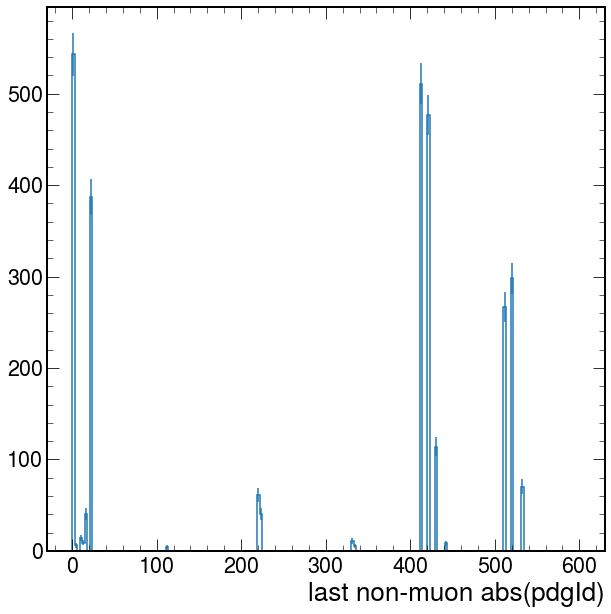

In [264]:
print("Status:")
print(last_parents.status[:3])
print("pdgId:")
print(last_parents.pdgId[:3])
print("above 550:")
print(ak.flatten(last_parents[ak.fill_none(last_parents.pdgId, 0) > 550].pdgId))
print(ak.num(ak.flatten(last_parents[ak.fill_none(last_parents.pdgId, 0) > 550].pdgId), axis=0))
(
    Hist.new
    .Regular(200, 0, 600, name="abs(pdgId)", label="last non-muon abs(pdgId)")#, transform=hist.axis.transform.log)
    .Double()
    .fill(abs(ak.fill_none(ak.flatten(last_parents.pdgId), 0)))
    .plot()
);
#plt.xscale("log")
#plt.yscale("log")

Status:
[[2, 2, 71], [71, 71, None], [2, 2, 2]]
pdgId:
[[111, -413, 4], [3, 3, None], [413, 433, 413]]
above 550:
[5122, 4112, 5224, 4214, 4224, 5214, 4224, 5122, 4222, 5224, 5114, 4314, 5122]
13


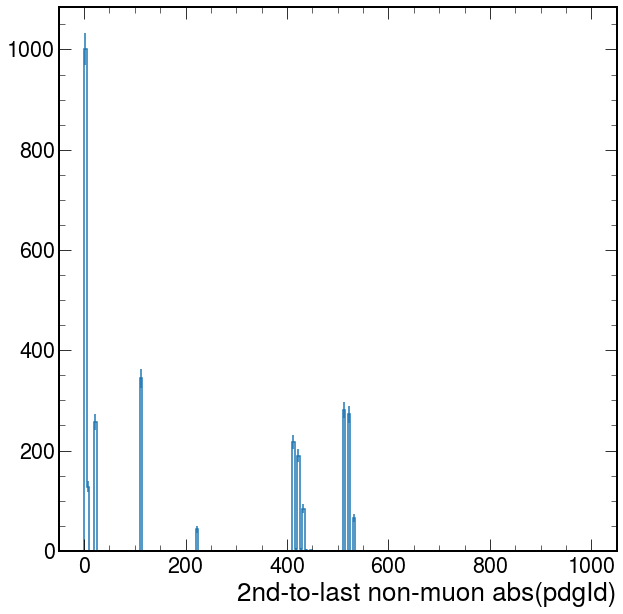

In [266]:
print("Status:")
print(last2nd_parents.status[:3])
print("pdgId:")
print(last2nd_parents.pdgId[:3])
print("above 550:")
print(ak.flatten(last2nd_parents[ak.fill_none(last2nd_parents.pdgId, 0) > 550].pdgId))
print(ak.num(ak.flatten(last2nd_parents[ak.fill_none(last2nd_parents.pdgId, 0) > 550].pdgId), axis=0))
(
    Hist.new
    .Regular(
        200, 0, 1000, 
        name="abs(pdgId)", 
        label="2nd-to-last non-muon abs(pdgId)")#, transform=hist.axis.transform.log)
    .Double()
    .fill(abs(ak.fill_none(ak.flatten(last2nd_parents.pdgId), 0)))
    .plot()
);
#plt.xscale("log")
#plt.yscale("log")

Status:
[[21, 21, 21], [21, 21, None], [21, 21, 21]]
pdgId:
[[21, 21, 21], [21, 21, None], [21, 21, 21]]
above 550:
[]
0


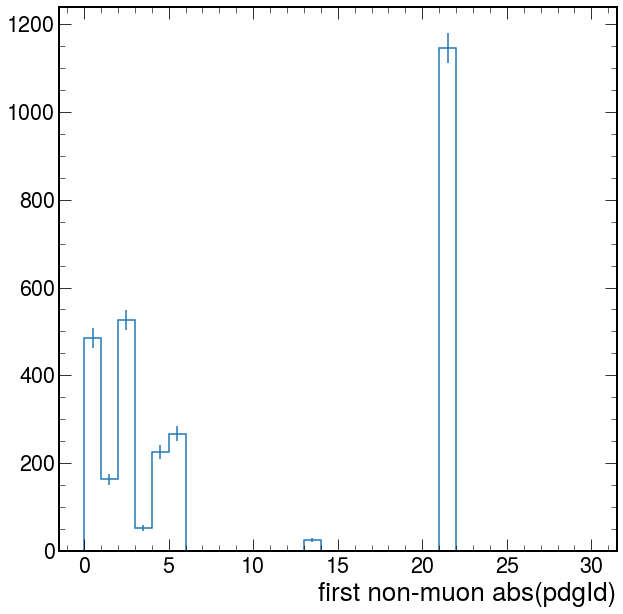

In [268]:
print("Status:")
print(first_parents.status[:3])
print("pdgId:")
print(first_parents.pdgId[:3])
print("above 550:")
print(ak.flatten(first_parents[ak.fill_none(first_parents.pdgId, 0) > 550].pdgId))
print(ak.num(ak.flatten(first_parents[ak.fill_none(first_parents.pdgId, 0) > 550].pdgId), axis=0))
(
    Hist.new
    .Regular(30, 0, 30, name="abs(pdgId)", label="first non-muon abs(pdgId)")#, transform=hist.axis.transform.log)
    .Double()
    .fill(abs(ak.fill_none(ak.flatten(first_parents.pdgId), 0)))
    .plot()
);
#plt.xscale("log")
#plt.yscale("log")

## Check default Nano gen-matching

In [50]:
Muons_s = events.Muon
muon_cleaning = (
    Muons_s.looseId
    & (Muons_s.pt > 3)
    & (abs(Muons_s.dxy) <= 0.02)
    & (abs(Muons_s.dz) <= 0.1)
    & (abs(Muons_s.eta) < 2.4)
)
Muons_s = Muons_s[muon_cleaning]
num_muons_selection = ak.num(Muons_s) >= 3
Muons_s = Muons_s[num_muons_selection]

In [51]:
Muons_s.genPartFlav

<Array [[3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3]] type='1838 * var * uint8[paramete...'>

In [23]:
Muons_b = events.Muon
muon_cleaning = (
    Muons_b.looseId
    & (Muons_b.pt > 3)
    & (abs(Muons_b.dxy) <= 0.02)
    & (abs(Muons_b.dz) <= 0.1)
    & (abs(Muons_b.eta) < 2.4)
)
Muons_b = Muons_b[muon_cleaning]
num_muons_selection = ak.num(Muons_b) >= 3
Muons_b = Muons_b[num_muons_selection]

(0.0, 1.05)

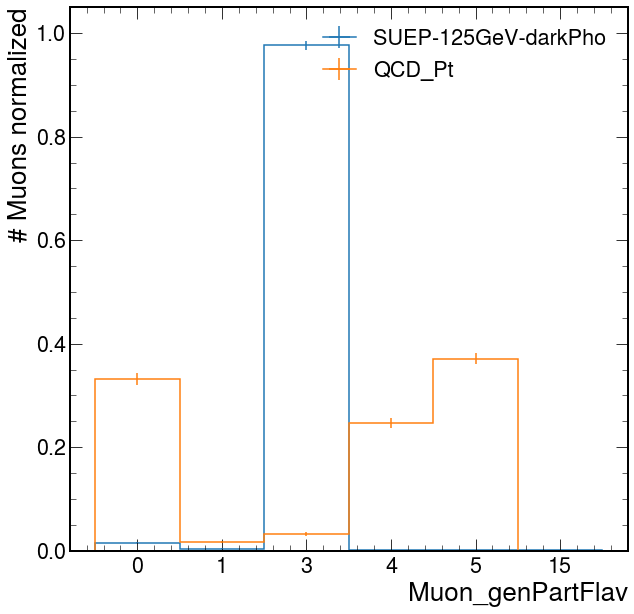

In [60]:
(
    Hist.new
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(Muons_s.genPartFlav))
    .plot(label="SUEP-125GeV-darkPho", density=True)
)
(
    Hist.new
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(Muons_b.genPartFlav))
    .plot(label="QCD_Pt", density=True)
);
plt.legend()
plt.ylabel("# Muons normalized")
#plt.yscale("log")
plt.ylim(0.00, 1.05)

In [272]:
events.Muon.genPartFlav

<Array [[5, 5, 0], [0, 4, ... 4], [5, 0, 0, 5]] type='2856 * var * uint8[paramet...'>

## TTBar sources

In [11]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 6
Muons = Muons[num_muons_selection]

MET = events.MET[num_muons_selection]

In [12]:
print(Muons.pt.to_numpy())

ValueError: in ListOffsetArray64, cannot convert to RegularArray because subarray lengths are not regular

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [137]:
print(Muons.genPartFlav.to_numpy())

[[ 4  4  5  5  5  0]
 [ 4  1  1  5  4  0]
 [ 1  5  4  4  5  0]
 [ 1  5 15  5  5  4]
 [ 1  0  0  5  0  0]
 [ 4  5  5  5  0  5]
 [ 0  4  4  5  5  0]]


In [138]:
print(Muons.genPartIdx.to_numpy())

[[66 54 72 64 83 -1]
 [57 17 18 60 46 -1]
 [17 75 66 72 77 -1]
 [20 64 48 75 70 56]
 [15 -1 -1 45 -1 -1]
 [65 85 75 71 -1 78]
 [-1 46 53 65 62 -1]]


In [139]:
GenPart = events.GenPart[num_muons_selection]

In [140]:
wbosons = GenPart[abs(GenPart.pdgId) == 24]
wbosons = wbosons[abs(wbosons.children.pdgId[:,:,0]) != 24]

In [141]:
print(wbosons.children.pdgId.to_list())

[[[4, -3], [3, -4]], [[14, -13], [13, -14]], [[14, -13], [3, -4]], [[16, -15], [13, -14]], [[14, -13], [1, -2]], [[2, -1], [3, -4]], [[4, -3], [3, -4]]]


In [142]:
print(wbosons.status.to_list())

[[52, 52], [52, 52], [52, 52], [52, 52], [52, 22], [52, 52], [52, 22]]


### Calculate and plot the mT

In [13]:
mT = np.sqrt(2*Muons.pt*MET.pt*(1-np.cos(Muons.delta_phi(MET))));

In [17]:
ak.flatten(mT)

<Array [9.14, 2.2, 6.49, ... 29.9, 35.3, 31.3] type='5920 * float32'>

In [18]:
weights = events.genWeight[num_muons_selection]

In [22]:
ak.flatten(ak.broadcast_arrays(weights, mT)[0])

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='5920 * float32[parameters=...'>

In [ ]:
events.Muon.

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb59f0235e0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb59ef18580>, text=[])

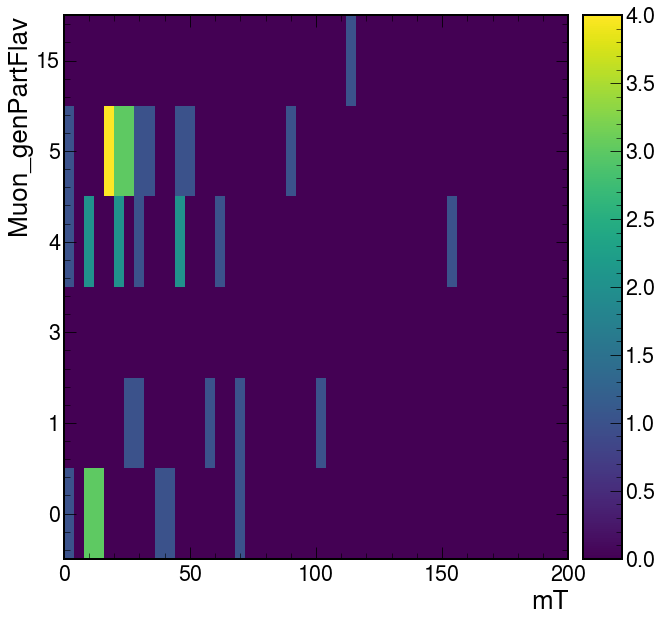

In [174]:
(
    Hist.new
    .Regular(100, 0, 100, name="mT", label="mT")
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(mT), ak.flatten(Muons.genPartFlav))
    .plot2d()
)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fb597c46d60>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fb597c5ce80>, text=[])

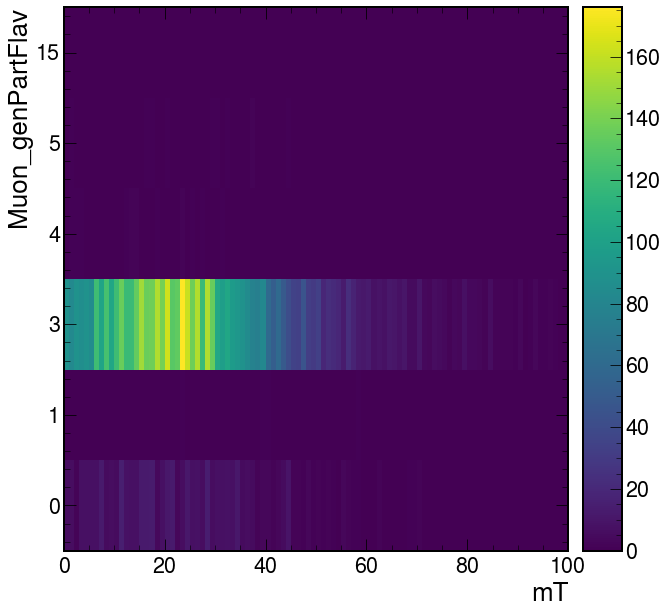

In [180]:
(
    Hist.new
    .Regular(100, 0, 100, name="mT", label="mT")
    .IntCategory([0,1,3,4,5,15], name="Muon_genPartFlav", label="Muon_genPartFlav")
    .Double()
    .fill(ak.flatten(mT), ak.flatten(Muons.genPartFlav))
    .plot2d()
)

## Check status flags

In [115]:
def check_flag(n, i):
    "Checks the nth flag for input i"
    return i & (2 ** n) != 0

In [150]:
genParts = events.GenPart[events.GenPart.status == 1]

In [159]:
#print(genParts[0].statusFlags.to_list())
for flag in range(0, 15):
    print(f"\n flag={flag}")
    print(genParts[check_flag(flag, genParts.statusFlags)][0].status.to_list())
    print(genParts[check_flag(flag, genParts.statusFlags)][0].pdgId.to_list())
    print([int(i) for i in check_flag(flag, genParts.statusFlags)[0].to_list()])


 flag=0
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=1
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=2
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=3
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=4
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=5
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=6
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-11, 12, 22, 22, 14, -13, 22, 22, 22, 13, -14, 22, 22, 22, 22, 22, 22]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 flag=7
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=8
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=9
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=10
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=11
[]
[]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 flag=12
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[-11, 12, 22, 

## Pt spectrum of matched vs unmatched muons

In [12]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 3
Muons = Muons[num_muons_selection]

gen_mask = (events.GenPart.status == 1)

gen_parts = events.GenPart[gen_mask]
gen_parts = gen_parts[num_muons_selection]
matched = Muons.nearest(gen_parts)
matched_f = Muons[Muons.delta_r(matched) < 0.1]
unmatched_f = Muons[Muons.delta_r(matched) > 0.1]

In [17]:
Muons_s = events.Muon
muon_cleaning = (
    Muons_s.looseId
    & (Muons_s.pt > 3)
    & (abs(Muons_s.dxy) <= 0.02)
    & (abs(Muons_s.dz) <= 0.1)
    & (abs(Muons_s.eta) < 2.4)
)
Muons_s = Muons_s[muon_cleaning]
num_muons_selection = ak.num(Muons_s) >= 3
Muons_s = Muons_s[num_muons_selection]

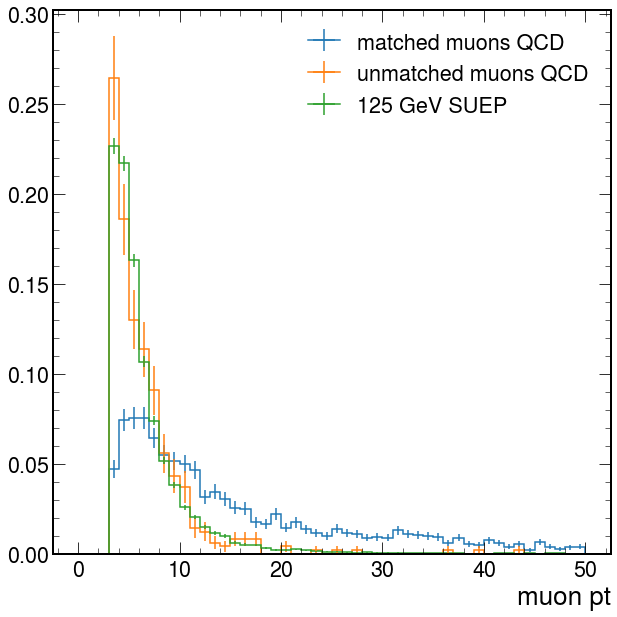

In [21]:
(
    Hist.new.Regular(50, 0, 50, name="muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(matched_f.pt))
    .plot(label="matched muons QCD", density=True)
)
(
    Hist.new.Regular(50, 0, 50, name="muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(unmatched_f.pt))
    .plot(label="unmatched muons QCD", density=True)
)
(
    Hist.new.Regular(50, 0, 50, name="muon pt", label="muon pt")
    .Double()
    .fill(ak.flatten(Muons_s.pt))
    .plot(label="125 GeV SUEP", density=True)
)
plt.legend()
#plt.yscale('log')

## Distance between gen-matched and reco muons

In [135]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 6
Muons = Muons[num_muons_selection]

gen_mask_1 = (
    (abs(events.GenPart.pdgId) == 13) &
    (events.GenPart.status == 1)
)
gen_mask_2 = (
    (abs(events.GenPart.pdgId) != 13) &
    (events.GenPart.status == 1)
)

gen_parts_1 = events.GenPart[gen_mask_1]
gen_parts_1 = gen_parts_1[num_muons_selection]
gen_parts_2 = events.GenPart[gen_mask_2]
gen_parts_2 = gen_parts_2[num_muons_selection]
matched_1 = Muons.nearest(gen_parts_1)
matched_2 = Muons.nearest(gen_parts_2)
matched_f_1 = ak.mask(matched_1, Muons.delta_r(matched_1) < 0.1)
matched_f_2 = ak.mask(matched_2, Muons.delta_r(matched_2) < 0.1)

matched_f = ak.where(~ak.is_none(matched_f_1, axis=1), matched_f_1, matched_f_2)

In [136]:
print(matched_f_1.pt[0])
print(matched_f_2.pt[0])
print(matched_f.pt[0])

[67, 49, 32.8, 21.4, 49, None, None]
[12.3, 22.8, 12.3, 25.2, 22.8, 1.54, 15.7]
[67, 49, 32.8, 21.4, 49, 1.54, 15.7]


In [137]:
ak.sum(ak.is_none(ak.flatten(matched_f))) / len(ak.flatten(matched_f))

0.35

In [140]:
~ak.is_none(matched_f_1, axis=1)

<Array [[True, True, True, ... False, False]] type='3 * var * bool'>

In [142]:
print(
    Muons.delta_r(matched_f)[0], 
    Muons.delta_r(matched_f)[1], 
    Muons.delta_r(matched_f)[2],
    #Muons.delta_r(matched_f)[3],
    #Muons.delta_r(matched_f)[4],
)

[0.00343, 0.00201, 0.00448, 0.000444, 0.000732, 0.035, 0.0109] [0.000644, None, 0.0564, 0.00199, None, 0.000504] [0.00228, None, 0.00253, None, None, None, None]


In [85]:
print(matched_f.pdgId[:5])
print(matched_f.pt[:5])
print(Muons.delta_r(matched_f)[:5])
print()
print(matched_f.children.pdgId[:3])
print(matched_f.children.status[:3])
print()
print(matched_f.children.children.pdgId[:3])
print(matched_f.children.children.status[:3])

[[13, -13, None, -13, 22, None], [13, ... None], [-13, 13, -13, None, None, None]]
[[88.5, 41.8, None, 10.4, 15.1, None], ... [54, 27.7, 13.6, None, None, None]]
[[0.000366, 0.000782, None, 0.000503, 0.0452, ... 0.00109, None, None, None]]

[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]
[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]

[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]
[[[], [], None, [], [], None], ... [], [], [], [], []], [[], [], [], None, [], None]]


In [86]:
matched_f.children[1]

<GenParticleArray [[], [], [], [], [], [], []] type='7 * option[var * ?genParticle]'>

In [87]:
print(ak.flatten(Muons[ak.fill_none(matched_f.eta, 0) == 0].eta))

[-1.02, -0.0196, -2.02, -1.91, -0.77, -0.734, 1.32, 1.18]


In [88]:
ak.flatten(Muons.eta)

<Array [-0.447, -0.281, -1.02, ... 1.32, 1.18] type='31 * float32[parameters={"_...'>

In [89]:
delta_r = ak.fill_none(ak.flatten(Muons.delta_r(matched_f)), 0)

In [90]:
ak.sum(delta_r > 0.1, axis=0) / len(delta_r)

0.0

In [91]:
print(delta_r[delta_r > 0.1])

[]


In [92]:
print(ak.flatten(matched_f.pdgId)[delta_r > 0.1])
print(ak.flatten(matched_f.status)[delta_r > 0.1])

[]
[]


In [93]:
print(ak.flatten(matched_f.pt)[delta_r > 0.1])

[]


In [94]:
print(ak.flatten(Muons.pt)[delta_r > 0.1])

[]


In [95]:
print(delta_r > 0.1)

[False, False, False, False, False, False, ... False, False, False, False, False]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f28a8562190>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

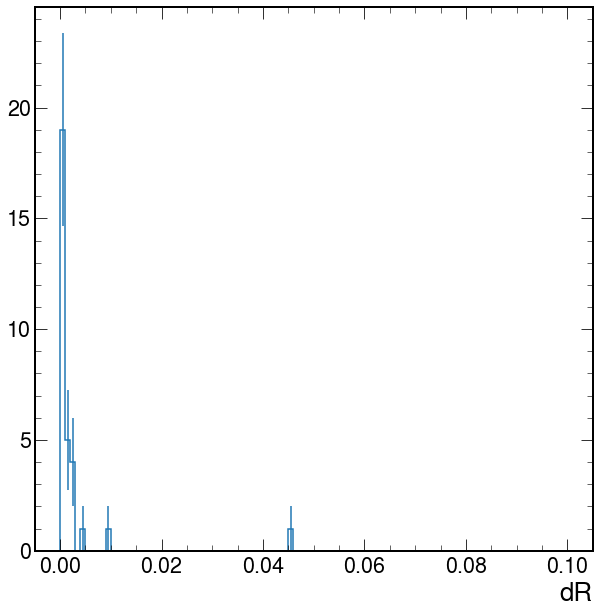

In [100]:
(
    Hist.new
    .Regular(100, 0, 0.1, name="dR", label="dR")#, transform=hist.axis.transform.log)
    .Double()
    .fill(ak.fill_none(ak.flatten(Muons.delta_r(matched_f)), 0))
    .plot()
)
#plt.xscale('log')
#plt.yscale('log');

## Check ak4jets for muon containment

In [239]:
Muons = events.Muon
muon_cleaning = (
    Muons.looseId
    & (Muons.pt > 3)
    & (abs(Muons.dxy) <= 0.02)
    & (abs(Muons.dz) <= 0.1)
    & (abs(Muons.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 4
Muons = Muons[num_muons_selection]

In [240]:
ak4jets = events.Jet
jet_cleaning = (
    (ak4jets.pt > 15)
    & (abs(ak4jets.eta) < 2.4)
)
ak4jets = ak4jets[jet_cleaning]
ak4jets = ak4jets[num_muons_selection]

In [241]:
delta_r = ak4jets.metric_table(Muons)
nMuonsInJets = ak.sum(delta_r < 0.4, axis=-1)
nMuonsInJets = ak.sort(nMuonsInJets, axis=-1, ascending=False)
nMuonsInJets = ak.fill_none(ak.pad_none(nMuonsInJets, 5, axis=-1), 0)

In [242]:
nMuonsInJets

<Array [[2, 1, 1, 1, 1, 1, ... 0, 0, 0, 0, 0]] type='5751 * var * int64'>

In [243]:
print(nMuonsInJets[:,0])
print(nMuonsInJets[:,1])
print(nMuonsInJets[:,2])
print(nMuonsInJets[:,3])
print(ak.sum(nMuonsInJets[:,4:], axis=1))

[2, 3, 1, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, ... 4, 6, 2, 7, 3, 2, 1, 3, 1, 11, 3, 1, 8]
[1, 2, 1, 1, 2, 1, 1, 3, 1, 2, 2, 2, 1, 1, ... 2, 3, 1, 4, 2, 1, 1, 2, 1, 6, 2, 1, 5]
[1, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 1, ... 1, 2, 1, 4, 2, 1, 1, 1, 1, 3, 2, 1, 5]
[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, ... 1, 2, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3]
[3, 5, 0, 1, 2, 0, 0, 5, 0, 1, 7, 1, 1, 0, ... 3, 4, 2, 5, 3, 4, 2, 0, 1, 6, 2, 2, 4]


In [244]:
print(ak.max(nMuonsInJets[:,0]))
print(ak.max(nMuonsInJets[:,1]))
print(ak.max(nMuonsInJets[:,2]))
print(ak.max(nMuonsInJets[:,3]))
print(ak.max(ak.sum(nMuonsInJets[:,4:], axis=1)))

21
11
10
8
17


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f6534647880>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f65345d8850>, text=[])

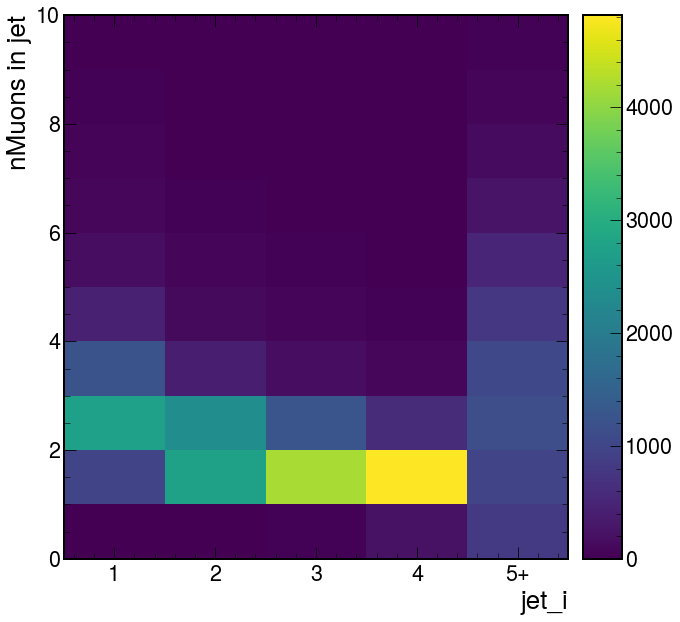

In [245]:
(
    Hist.new
    .StrCategory(["1", "2", "3", "4", "5+"], name="jet_i", label="jet_i")
    .Regular(10, 0, 10, name="nMuonsInJet", label="nMuons in jet")
    .Double()
    .fill("1", nMuonsInJets[:,0])
    .fill("2", nMuonsInJets[:,1])
    .fill("3", nMuonsInJets[:,2])
    .fill("4", nMuonsInJets[:,3])
    .fill("5+", ak.sum(nMuonsInJets[:,4:], axis=1))
.plot2d()
)

## Check ak8jets for muon containment

In [10]:
Muons = ak.zip(
    {
        "pt": events.Muon.pt,
        "eta": events.Muon.eta,
        "phi": events.Muon.phi,
        "mass": events.Muon.mass,
    },
    with_name="Momentum4D"
)
muon_cleaning = (
    events.Muon.looseId
    & (events.Muon.pt > 3)
    & (abs(events.Muon.dxy) <= 0.02)
    & (abs(events.Muon.dz) <= 0.1)
    & (abs(events.Muon.eta) < 2.4)
)
Muons = Muons[muon_cleaning]
num_muons_selection = ak.num(Muons) >= 4
Muons = Muons[num_muons_selection]

In [11]:
pfcands = ak.zip(
    {
        "pt": events.PFCands.trkPt,
        "eta": events.PFCands.trkEta,
        "phi": events.PFCands.trkPhi,
        "mass": events.PFCands.mass,
    },
    with_name="Momentum4D",
)
cutPFCands = (
    (events.PFCands.fromPV > 1)
    & (events.PFCands.trkPt >= 0.75)
    & (abs(events.PFCands.trkEta) <= 2.5)
    & (abs(events.PFCands.dz) < 10)
    & (events.PFCands.dzErr < 0.05)
)
pfcands = pfcands[cutPFCands]

jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.5)
cluster = fastjet.ClusterSequence(pfcands, jetdef)
ak15jets = cluster.inclusive_jets(min_pt=30)
ak15clusters = cluster.constituents(min_pt=30)

jet_cleaning = (
    (ak15jets.pt > 30)
    & (abs(ak15jets.eta) < 2.4)
)
ak15jets = ak15jets[jet_cleaning]
ak15jets = ak15jets[num_muons_selection]
ak15clusters = ak15clusters[jet_cleaning]
ak15clusters = ak15clusters[num_muons_selection]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [12]:
ak.where(ak.num(ak15jets) == 1)

(<Array [179, 243, 264, ... 901, 1034, 1425] type='7 * int64'>,)

In [22]:
def getTopTwoJets(ak_inclusive_jets, ak_inclusive_cluster):
    # order the reclustered jets by pT (will take top 2 for ISR removal method)
    # make sure there are at least 2 entries in the array
    ak_inclusive_jets = ak.pad_none(ak_inclusive_jets, 2, axis=1)
    ak_inclusive_cluster = ak.pad_none(ak_inclusive_cluster, 2, axis=1)
    highpt_jet = ak.argsort(ak_inclusive_jets.pt, axis=1, ascending=False, stable=True)
    jets_pTsorted = ak_inclusive_jets[highpt_jet]
    clusters_pTsorted = ak_inclusive_cluster[highpt_jet]

    # at least 2 tracks in SUEP
    singletrackCut = ak.num(clusters_pTsorted[:, 0]) > 1
    jets_pTsorted = jets_pTsorted[singletrackCut]
    clusters_pTsorted = clusters_pTsorted[singletrackCut]

    # number of constituents per jet, sorted by pT
    nconst_pTsorted = ak.fill_none(ak.num(clusters_pTsorted, axis=-1), 0)
    print(nconst_pTsorted[179, 1],nconst_pTsorted[179, 0])
    print(nconst_pTsorted[179, 1] <= nconst_pTsorted[179, 0])
    print(jets_pTsorted[179, 0])
    
    print(ak.where(
        nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
        jets_pTsorted[:, 0],
        jets_pTsorted[:, 1],
    )[179])
    
    # Top 2 pT jets. If jet1 has fewer tracks than jet2 then swap
    SUEP_cand = ak.where(
        nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
        jets_pTsorted[:, 0],
        jets_pTsorted[:, 1],
    )
    SUEP_cand = ak.where(ak.is_none(SUEP_cand), jets_pTsorted[:, 0], SUEP_cand)
    print(SUEP_cand[179])

    return SUEP_cand

In [23]:
SUEP_cand = getTopTwoJets(ak15jets, ak15clusters)

0 118
True
{px: 220, py: -97.8, pz: -135, E: 353}
None
{px: 220, py: -97.8, pz: -135, E: 353}


In [24]:
ak.is_none(SUEP_cand)[179]

False

In [54]:
ak_inclusive_jets = ak.pad_none(ak15jets, 2, axis=1)
ak_inclusive_cluster = ak.pad_none(ak15clusters, 2, axis=1)
highpt_jet = ak.argsort(ak_inclusive_jets.pt, axis=1, ascending=False, stable=True)
jets_pTsorted = ak_inclusive_jets[highpt_jet]
clusters_pTsorted = ak_inclusive_cluster[highpt_jet]
singletrackCut = ak.num(clusters_pTsorted[:, 0]) > 1
jets_pTsorted = jets_pTsorted[singletrackCut]
clusters_pTsorted = clusters_pTsorted[singletrackCut]
nconst_pTsorted = ak.fill_none(ak.num(clusters_pTsorted, axis=-1), 0)

In [55]:
nconst_pTsorted[179]

<Array [118, 0] type='2 * int64'>

In [63]:
SUEP_cand = ak.where(
    nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
    jets_pTsorted[:, 0],
    jets_pTsorted[:, 1],
)

In [75]:
jets_pTsorted[179, 1]

In [73]:
ak.where(nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],0,1)[180]

0

In [41]:
a, b = ak.unzip(
    ak.cartesian([ak15jets, Muons], axis=1, nested=True)
)
delta_r = a.deltaR(b)
nMuonsInJets = ak.sum(delta_r < 1.5, axis=-1)
nMuonsInJets = ak.sort(nMuonsInJets, axis=-1, ascending=False)
nMuonsInJets = ak.fill_none(ak.pad_none(nMuonsInJets, 3, axis=-1), 0)

In [42]:
nMuonsInJets

<Array [[4, 2, 2, 0], [7, ... 0], [19, 9, 0]] type='5751 * var * int64'>

In [43]:
print(nMuonsInJets[:,0])
print(nMuonsInJets[:,1])
print(ak.sum(nMuonsInJets[:,2:], axis=1))

[4, 7, 2, 4, 6, 4, 4, 9, 4, 5, 7, 5, 5, ... 13, 3, 16, 5, 6, 4, 4, 2, 17, 8, 4, 19]
[2, 5, 2, 2, 3, 3, 1, 4, 3, 3, 6, 4, 3, 0, ... 4, 1, 3, 6, 5, 3, 3, 2, 2, 4, 1, 3, 9]
[2, 0, 1, 0, 2, 2, 0, 2, 1, 0, 4, 2, 1, 0, ... 0, 0, 2, 5, 3, 2, 2, 0, 1, 0, 1, 1, 0]


In [44]:
print(ak.max(nMuonsInJets[:,0]))
print(ak.max(nMuonsInJets[:,1]))
print(ak.max(ak.sum(nMuonsInJets[:,2:], axis=1)))

32
17
13


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f64de063550>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f64de4adeb0>, text=[])

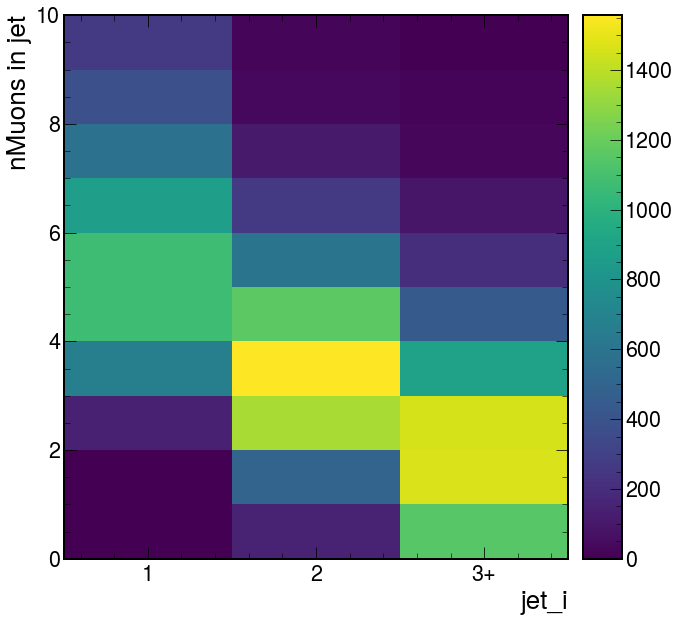

In [45]:
(
    Hist.new
    .StrCategory(["1", "2", "3+"], name="jet_i", label="jet_i")
    .Regular(10, 0, 10, name="nMuonsInJet", label="nMuons in jet")
    .Double()
    .fill("1", nMuonsInJets[:,0])
    .fill("2", nMuonsInJets[:,1])
    .fill("3+", ak.sum(nMuonsInJets[:,2:], axis=1))
.plot2d()
)

### Invariant mass tests

In [192]:
Zs = ak.combinations(muons, n=2, axis=-1, highlevel=True, with_name="Momentum4D")
mu1, mu2 = ak.unzip(Zs)
opposite_charges = (mu1.charge != mu2.charge)
dimuon = mu1[opposite_charges] + mu2[opposite_charges]

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0e13e475e0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

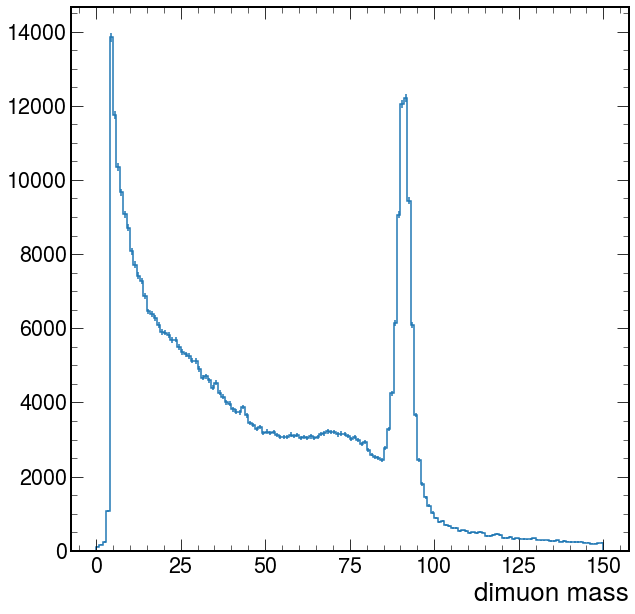

In [193]:
h_dimuon_mass.fill(ak.flatten(dimuon.mass)).plot()

In [83]:
cutflow.fill(len(events) * ['nMuon_mediumId > 6'], weight=events.genWeight)


Hist(StrCategory(['total', 'trigger', 'nMuon_mediumId > 6'], name='cutflow', label='cutflow'), storage=Weight()) # Sum: WeightedSum(value=3728.77, variance=69.3721)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f94bc06d940>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

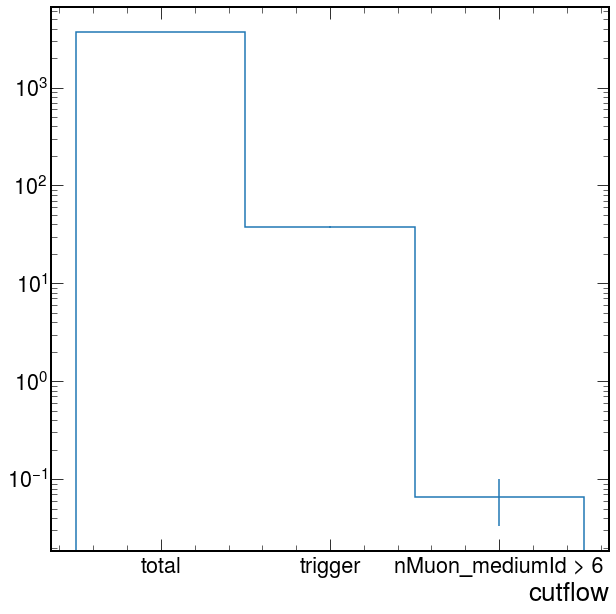

In [84]:
plt.yscale('log')
cutflow *= factor
cutflow.plot()

In [37]:
cat1 = Muons.mediumId
cat2 = Muons.isTracker & ~Muons.mediumId
cat3 = ~cat1 & ~cat2

(array([9243.,  242.,   38.,    2.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ]),
 [<matplotlib.patches.Polygon at 0x7f7c19fac9d0>])

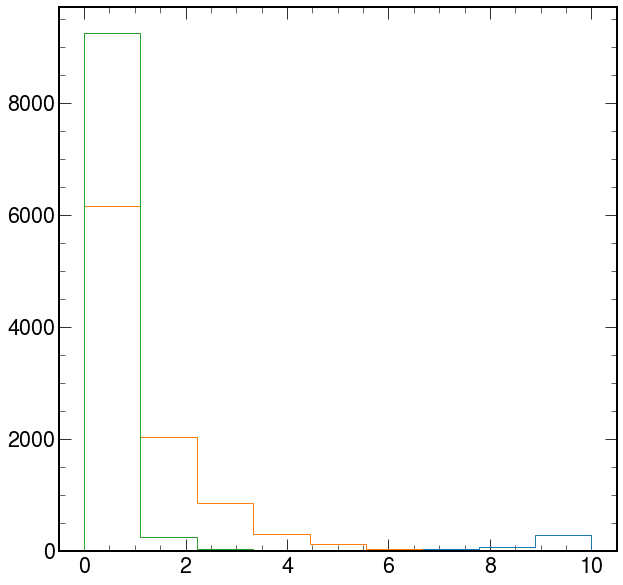

In [38]:
plt.hist(ak.sum(cat1, axis=-1), bins=np.linspace(0,10,10), histtype='step', label='cat1')
plt.hist(ak.sum(cat2, axis=-1), bins=np.linspace(0,10,10), histtype='step', label='cat1')
plt.hist(ak.sum(cat3, axis=-1), bins=np.linspace(0,10,10), histtype='step', label='cat1')

In [13]:
pfcands = ak.zip(
    {
        "pt": events.PFCands.trkPt,
        "eta": events.PFCands.trkEta,
        "phi": events.PFCands.trkPhi,
        "mass": events.PFCands.mass,
    },
    with_name="Momentum4D",
)
cutPFCands = (
    (events.PFCands.fromPV > 1)
    & (events.PFCands.trkPt >= 0.75)
    & (abs(events.PFCands.trkEta) <= 2.5)
    & (abs(events.PFCands.dz) < 10)
    & (events.PFCands.dzErr < 0.05)
)
pfcands = pfcands[cutPFCands]

In [22]:
import fastjet

In [23]:
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.5)
cluster = fastjet.ClusterSequence(pfcands, jetdef)
ak_inclusive_jets = cluster.inclusive_jets()
ak_inclusive_cluster = cluster.constituents()
minPtCut = ak_inclusive_jets.pt > 150
ak_inclusive_jets = ak_inclusive_jets[minPtCut]
ak_inclusive_cluster = ak_inclusive_cluster[minPtCut]

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [25]:
indices = np.arange(0, len(pfcands))
clusterCut = ak.num(ak_inclusive_jets, axis=1) > 1
ak_inclusive_cluster = ak_inclusive_cluster[clusterCut]
ak_inclusive_jets = ak_inclusive_jets[clusterCut]
pfcands = pfcands[clusterCut]
indices = indices[clusterCut]

In [30]:
highpt_jet = ak.argsort(ak_inclusive_jets.pt, axis=1, ascending=False, stable=True)
jets_pTsorted = ak_inclusive_jets[highpt_jet]
clusters_pTsorted = ak_inclusive_cluster[highpt_jet]

In [34]:
singletrackCut = (ak.num(clusters_pTsorted[:, 0]) > 1) & (
    ak.num(clusters_pTsorted[:, 1]) > 1
)
jets_pTsorted = jets_pTsorted[singletrackCut]
clusters_pTsorted = clusters_pTsorted[singletrackCut]
pfcands = pfcands[singletrackCut]
indices = indices[singletrackCut]

In [36]:
nconst_pTsorted = ak.num(clusters_pTsorted, axis=-1)

SUEP_cand = ak.where(
    nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
    jets_pTsorted[:, 0],
    jets_pTsorted[:, 1],
)
ISR_cand = ak.where(
    nconst_pTsorted[:, 1] > nconst_pTsorted[:, 0],
    jets_pTsorted[:, 0],
    jets_pTsorted[:, 1],
)
SUEP_cluster_tracks = ak.where(
    nconst_pTsorted[:, 1] <= nconst_pTsorted[:, 0],
    clusters_pTsorted[:, 0],
    clusters_pTsorted[:, 1],
)
ISR_cluster_tracks = ak.where(
    nconst_pTsorted[:, 1] > nconst_pTsorted[:, 0],
    clusters_pTsorted[:, 0],
    clusters_pTsorted[:, 1],
)

In [38]:
len(pfcands)

0

In [136]:
electrons = ak.zip(
    {
        "pt": events.Electron.pt,
        "eta": events.Electron.eta,
        "phi": events.Electron.phi,
        "mass": events.Electron.mass,
        "charge": events.Electron.pdgId / (-11),
    },
    with_name="Momentum4D",
)
cutElectrons = (
    (events.Electron.mvaFall17V2noIso_WPL)
    & (events.Electron.pt >= 3)
    & (abs(events.Electron.dxy) < 0.05 + 0.05 * (abs(events.Electron.eta) > 1.479))
    & (abs(events.Electron.dz) < 0.10 + 0.10 * (abs(events.Electron.eta) > 1.479))
    & ((abs(events.Electron.eta) < 1.444) | (abs(events.Electron.eta) > 1.566))
    & (abs(events.Electron.eta) < 2.5)
)
electrons = electrons[cutElectrons]

In [137]:
leptons = ak.concatenate([muons, electrons], axis=-1)

In [149]:
def inter_isolation(leptons_1, leptons_2, dR=1.6):
    """
    Compute the inter-isolation of each particle. It is supposed to work for one particle per event. The input is:
    - leptons_1: array of leptons for isolation calculation
    - leptons_2: array of all leptons in the events
    - dR: deltaR cut for isolation calculation
    """
    a, b = ak.unzip(ak.cartesian([leptons_1, leptons_2]))
    deltar_mask = a.deltaR(b) < dR
    return (ak.sum(b[deltar_mask].pt, axis=-1) - leptons_1.pt) / leptons_1.pt

In [151]:
leptons

<MomentumArray4D [[{pt: 9.24, ... charge: -1}]] type='9525 * var * Momentum4D["p...'>

In [150]:
iso_new = inter_iso_new(leptons[:, 0], leptons)

ValueError: in NumpyArray, too many dimensions in slice

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/libawkward/array/NumpyArray.cpp#L4394)

In [146]:
iso_new

<Array [3.64, 7.48, 9.75, ... 11, 12, 9.89] type='9525 * float32'>

In [38]:
iso_leadingMuon = interIsolation(
    ak.materialized(muons[:,0]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)
iso_subleadingMuon = interIsolation(
    ak.materialized(muons[:,1]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)
iso_subsubleadingMuon = interIsolation(
    ak.materialized(muons[:,2]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)

In [139]:
%%timeit
iso_leadingMuon = interIsolation(
    ak.materialized(muons[:,0]), 
    ak.materialized(electrons), 
    ak.materialized(muons)
)

26.1 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
B_iso_leadingMuon = iso_leadingMuon

In [105]:
S_iso_leadingMuon = iso_leadingMuon

In [112]:
hS = Hist.new.Regular(25, 0, 10, name="inter-iso signal").Double()
hB = Hist.new.Regular(25, 0, 10, name="inter-iso bkg").Double()
hS.fill(S_iso_leadingMuon)
hB.fill(B_iso_leadingMuon)

Hist(Regular(25, 0, 10, name='inter-iso bkg', label='inter-iso bkg'), storage=Double()) # Sum: 280.0

In [114]:
hB

Hist(Regular(25, 0, 10, name='inter-iso bkg', label='inter-iso bkg'), storage=Double()) # Sum: 280.0

In [153]:
binning = np.linspace(0,10,25)
alpha = 2
beta = 5
nBins = hS.shape[0]
S = np.zeros(nBins)
B = np.zeros(nBins)
punzi1 = np.zeros(nBins)
punzi2 = np.zeros(nBins)
punzi3 = np.zeros(nBins)
SoverB = np.zeros(nBins)
SoverBandS = np.zeros(nBins)
for i in range(nBins):
    S[i] = hS[i:].sum()
    B[i] = hB[i:].sum()
    epsilon = S[i]/hS.sum()
    punziCommon = alpha*math.sqrt(B[i])+(beta/2)*math.sqrt(beta**2+4*alpha*math.sqrt(B[i])+4*B[i])
    punzi1[i] = epsilon / ((alpha**2)/2 + math.sqrt(B[i]))
    punzi2[i] = epsilon / ((beta**2)/2 + punziCommon)
    punzi3[i] = epsilon / ((alpha**2)/8 + 9*(beta**2)/13 + punziCommon)
    if B[i] > 0:
        SoverB[i] = epsilon / math.sqrt(B[i])
    if (B[i] + S[i]) > 0:
        SoverBandS[i] = epsilon / math.sqrt(B[i] + S[i])
print(f"punzi max at: {binning[np.argmax(punzi)]}")

punzi max at: 2.916666666666667


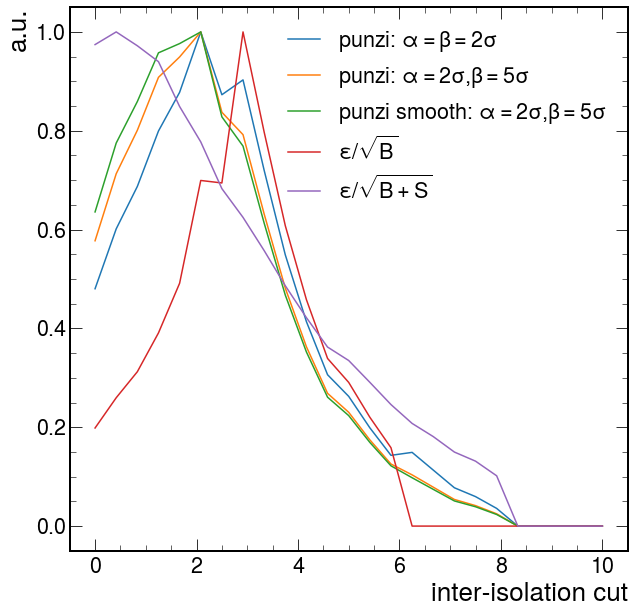

In [157]:
binning = np.linspace(0,10,25)
plt.plot(binning, punzi1/np.max(punzi1), label=r'punzi: $\alpha=\beta=2\sigma$')
plt.plot(binning, punzi2/np.max(punzi2), label=r'punzi: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, punzi3/np.max(punzi3), label=r'punzi smooth: $\alpha=2\sigma$,$\beta=5\sigma$')
plt.plot(binning, SoverB/np.max(SoverB), label=r'$\epsilon/\sqrt{B}$')
plt.plot(binning, SoverBandS/np.max(SoverBandS), label=r'$\epsilon/\sqrt{B+S}$')
plt.xlabel('inter-isolation cut')
plt.ylabel('a.u.')
plt.legend()

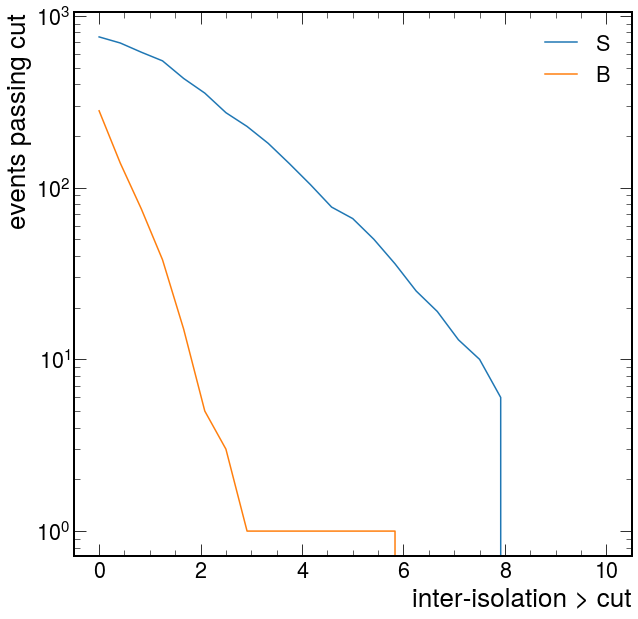

In [158]:
binning = np.linspace(0,10,25)
plt.plot(binning, S, label=r'$S$')
plt.plot(binning, B, label=r'$B$')
plt.xlabel('inter-isolation > cut')
plt.ylabel('events passing cut')
plt.yscale('log')
plt.legend()

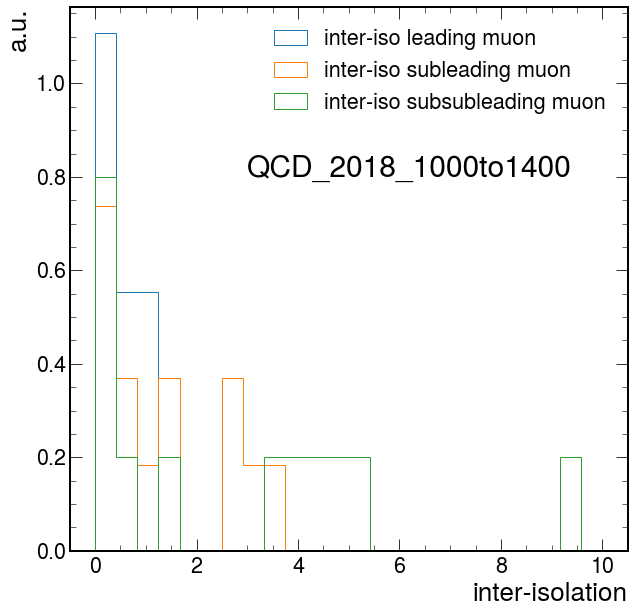

In [12]:
plt.hist(iso_leadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso leading muon')
plt.hist(iso_subleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subleading muon')
plt.hist(iso_subsubleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subsubleading muon')
plt.text(3,0.8,'QCD_2018_1000to1400',fontsize=30)
plt.xlabel('inter-isolation')
plt.ylabel('a.u.')
#plt.yscale('log')
plt.legend()

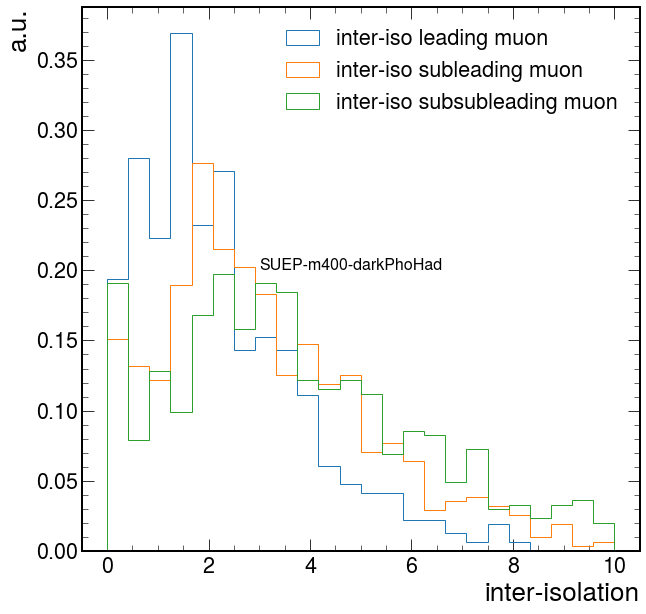

In [45]:
plt.hist(iso_leadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso leading muon')
plt.hist(iso_subleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subleading muon')
plt.hist(iso_subsubleadingMuon, bins=np.linspace(0,10,25), histtype='step', density=True, label='inter-iso subsubleading muon')
plt.text(3,0.2,'SUEP-m400-darkPhoHad',fontsize=16)
#plt.yscale('log')
plt.xlabel('inter-isolation')
plt.ylabel('a.u.')
plt.legend()

In [60]:
idx = [
    [0,0],
    [1,0],
    [0,1],
    [1,1],
]
for i_evt in range(4):
    i=idx[i_evt][0]
    j=idx[i_evt][1]
    print(i, j)

0 0
1 0
0 1
1 1


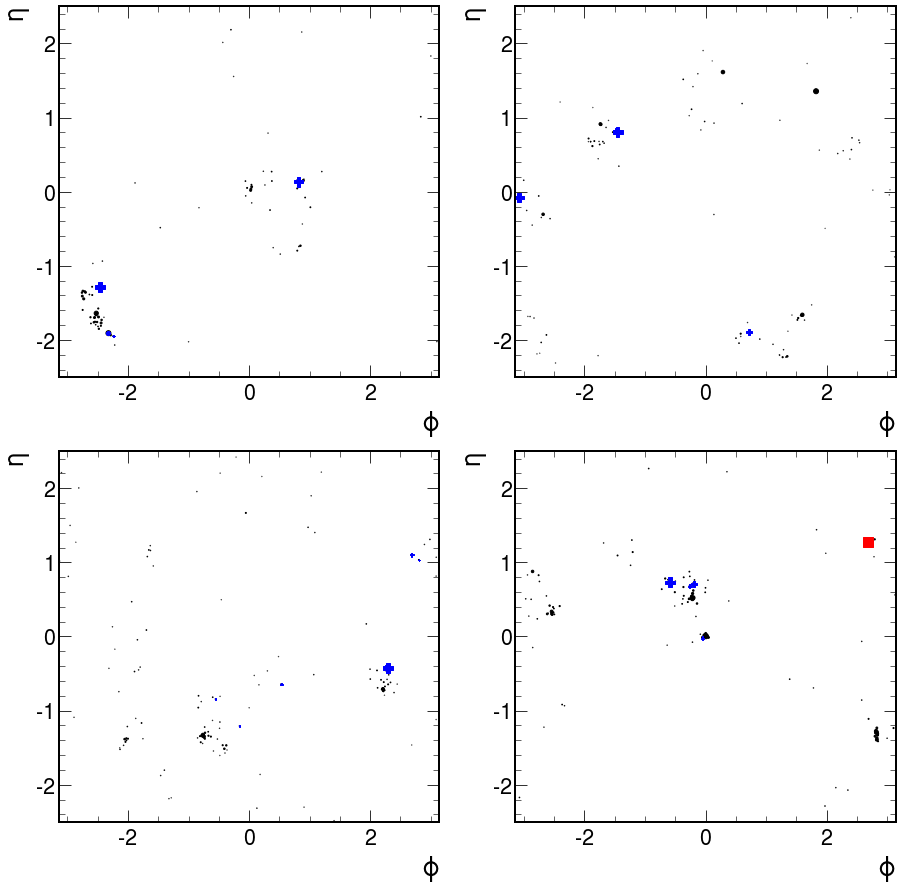

In [24]:
idx = [
    [0,0],
    [1,0],
    [0,1],
    [1,1],
]
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
marker_factor = 100
for i_evt in range(4):
    i=idx[i_evt][0]
    j=idx[i_evt][1]
    ax[i,j].scatter(
        pfcands[i_evt].phi,
        pfcands[i_evt].eta,
        s=marker_factor*pfcands[i_evt].pt/ak.max(pfcands[i_evt].pt),
        color='black',
        marker='.',
    )
    ax[i,j].scatter(
        muons[i_evt].phi,
        muons[i_evt].eta,
        s=marker_factor*muons[i_evt].pt/ak.max(muons[i_evt].pt),
        color='blue',
        marker='P',
    )
    if len(electrons[i_evt]) > 0:
        ax[i,j].scatter(
            electrons[i_evt].phi,
            electrons[i_evt].eta,
            s=marker_factor*electrons[i_evt].pt/ak.max(electrons[i_evt].pt),
            color='red',
            marker='s',
        )
    ax[i,j].axis(xmin=-math.pi,xmax=math.pi)
    ax[i,j].axis(ymin=-2.5, ymax=2.5)
    ax[i,j].set_xlabel(r'$\phi$')
    ax[i,j].set_ylabel(r'$\eta$')
fig.show()